**Nombre:** Ignacio Fernández Sánchez-Pascuala; Javier Castellano Soria

**NOTA**: Algunas celdas tardan bastante en ejecutarse. No ejecutar si no se quiere perder el resultado

**Curso 2023-2024 - JGO & GVC**

**Máster TECI - Redes Bayesianas (UCM)**

# Práctica Final

## Problema

Paper de referencia: https://www.jstor.org/stable/2245959

El paper presenta una revisión de los avances recientes en la aplicación de la teoría probabilística y estadística bayesiana a los sistemas expertos. Se describe cómo el conocimiento cualitativo y cuantitativo puede representarse en un modelo gráfico dirigido conocido como red de creencias, y se ilustra su uso en un ejemplo médico moderadamente complejo. Se discute cómo es posible hacer inferencia probabilística exacta en casos individuales utilizando un procedimiento de propagación general. Además, se presenta cómo las técnicas estadísticas bayesianas pueden utilizarse para actualizar las entradas cuantitativas subjetivas originales cuando hay disponibles datos de una serie de casos. Se explican algunas herramientas diagnósticas para identificar conflictos entre los datos y la especificación previa. También se explora un procedimiento de comparación de modelos y se establecen vínculos con los métodos estadísticos convencionales. Finalmente, se proporcionan detalles sobre el uso de distribuciones de prioridad de Dirichlet para aprender sobre los parámetros y sobre el proceso de transformar el modelo gráfico original a un árbol de unión como base para una computación eficiente. En general, este trabajo se enfoca en la aplicación de la teoría bayesiana a la representación y actualización del conocimiento en sistemas expertos, y proporciona herramientas útiles para el análisis y la interpretación de datos médicos complejos.

## Importa las librerías que vayas a usar.

In [ ]:
!pip install pgmpy
!pip install cdt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 921.1/921.1 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7393 sha256=6faeb7df6608e2aa0344ff1c3cc9944cfd882d3a79025dd7601258d206dec720
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
  Created wheel for skrebate: filename=skrebate-0.62-py3-none-any.whl size=29253 sha256=051a4da225a1665a8b08aa357cd5bd1d40507a6b217dbaea6e200db78eb289c7
  Stored in directory: /root/.cache/pip/wheels/dd/67/40/683074a684607162bd0e34dcf7ccdfcab5861c3b2a83286f3a
Successfully built GPUtil skrebate


In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import gzip
import cdt
import random
import copy
import networkx as nx
from scipy.stats import chi2_contingency, ttest_ind, entropy
from pgmpy.models import BayesianModel, BayesianNetwork
from pgmpy.estimators import ParameterEstimator, PC, HillClimbSearch, BDeuScore,\
K2Score, BicScore, MaximumLikelihoodEstimator, BayesianEstimator, ExhaustiveSearch, MmhcEstimator, TreeSearch
from pgmpy.metrics import log_likelihood_score, structure_score
from pgmpy.readwrite import BIFReader, BIFWriter
from pgmpy.inference import VariableElimination, ApproxInference, BeliefPropagation
from sklearn.model_selection import KFold

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


## Importa la base de datos y construye un dataframe. Realiza un análisis exploratorio sobre los datos:

* Número de registros
* Tipos de variables
* Distribución de las variables
* Análisis de relación (alternativa para categóricas, entropía, información muta)
* Algún test de hipótesis para validar relación.
* Gráficos

In [ ]:
#Leemos el Dataframe:
archivo_csv = "prueba_final_rb.csv"
dataframe = pd.read_csv(archivo_csv)

### Número de registros

In [ ]:
print("Número de registros:", len(dataframe))

Número de registros: 10000


### Tipos de variables
Se observa que todas las variables son categóricas, menos el identificador.

In [ ]:
# Información general
print("\nInformación general:")
print(dataframe.info())


Información general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      10000 non-null  int64 
 1   BirthAsphyxia   10000 non-null  object
 2   HypDistrib      10000 non-null  object
 3   HypoxiaInO2     10000 non-null  object
 4   CO2             10000 non-null  object
 5   ChestXray       10000 non-null  object
 6   Grunting        10000 non-null  object
 7   LVHreport       10000 non-null  object
 8   LowerBodyO2     10000 non-null  object
 9   RUQO2           10000 non-null  object
 10  CO2Report       10000 non-null  object
 11  XrayReport      10000 non-null  object
 12  Disease         10000 non-null  object
 13  GruntingReport  10000 non-null  object
 14  Age             10000 non-null  object
 15  LVH             10000 non-null  object
 16  DuctFlow        10000 non-null  object
 17  CardiacMixing   10000 non-nul

### Distribución de las variables

In [ ]:
#Eliminamos el identificador
dataframe = dataframe.drop(columns=['Unnamed: 0'])

In [ ]:
# Distribución de las variables categóricas
print("\nDistribución de las variables categóricas:")
for columna in dataframe.columns:
      print(f"\n{columna}:")
      print(dataframe[columna].value_counts()/10000)


Distribución de las variables categóricas:

BirthAsphyxia:
no     0.8997
yes    0.1003
Name: BirthAsphyxia, dtype: float64

HypDistrib:
Equal      0.9019
Unequal    0.0981
Name: HypDistrib, dtype: float64

HypoxiaInO2:
Moderate    0.504
Severe      0.383
Mild        0.113
Name: HypoxiaInO2, dtype: float64

CO2:
Normal    0.7139
High      0.1963
Low       0.0898
Name: CO2, dtype: float64

ChestXray:
Oligaemic    0.3411
Plethoric    0.2184
Normal       0.2146
Asy/Patch    0.1326
Grd_Glass    0.0933
Name: ChestXray, dtype: float64

Grunting:
no     0.7711
yes    0.2289
Name: Grunting, dtype: float64

LVHreport:
no     0.7157
yes    0.2843
Name: LVHreport, dtype: float64

LowerBodyO2:
5-12    0.4784
<5      0.3769
12+     0.1447
Name: LowerBodyO2, dtype: float64

RUQO2:
5-12    0.4939
<5      0.3463
12+     0.1598
Name: RUQO2, dtype: float64

CO2Report:
<7.5     0.7381
>=7.5    0.2619
Name: CO2Report, dtype: float64

XrayReport:
Oligaemic     0.3000
Normal        0.2451
Plethoric     0.21

### Análisis de relaciones, tests y gráficos

* Análisis Independencia de variables con el test chi-cuadrado:

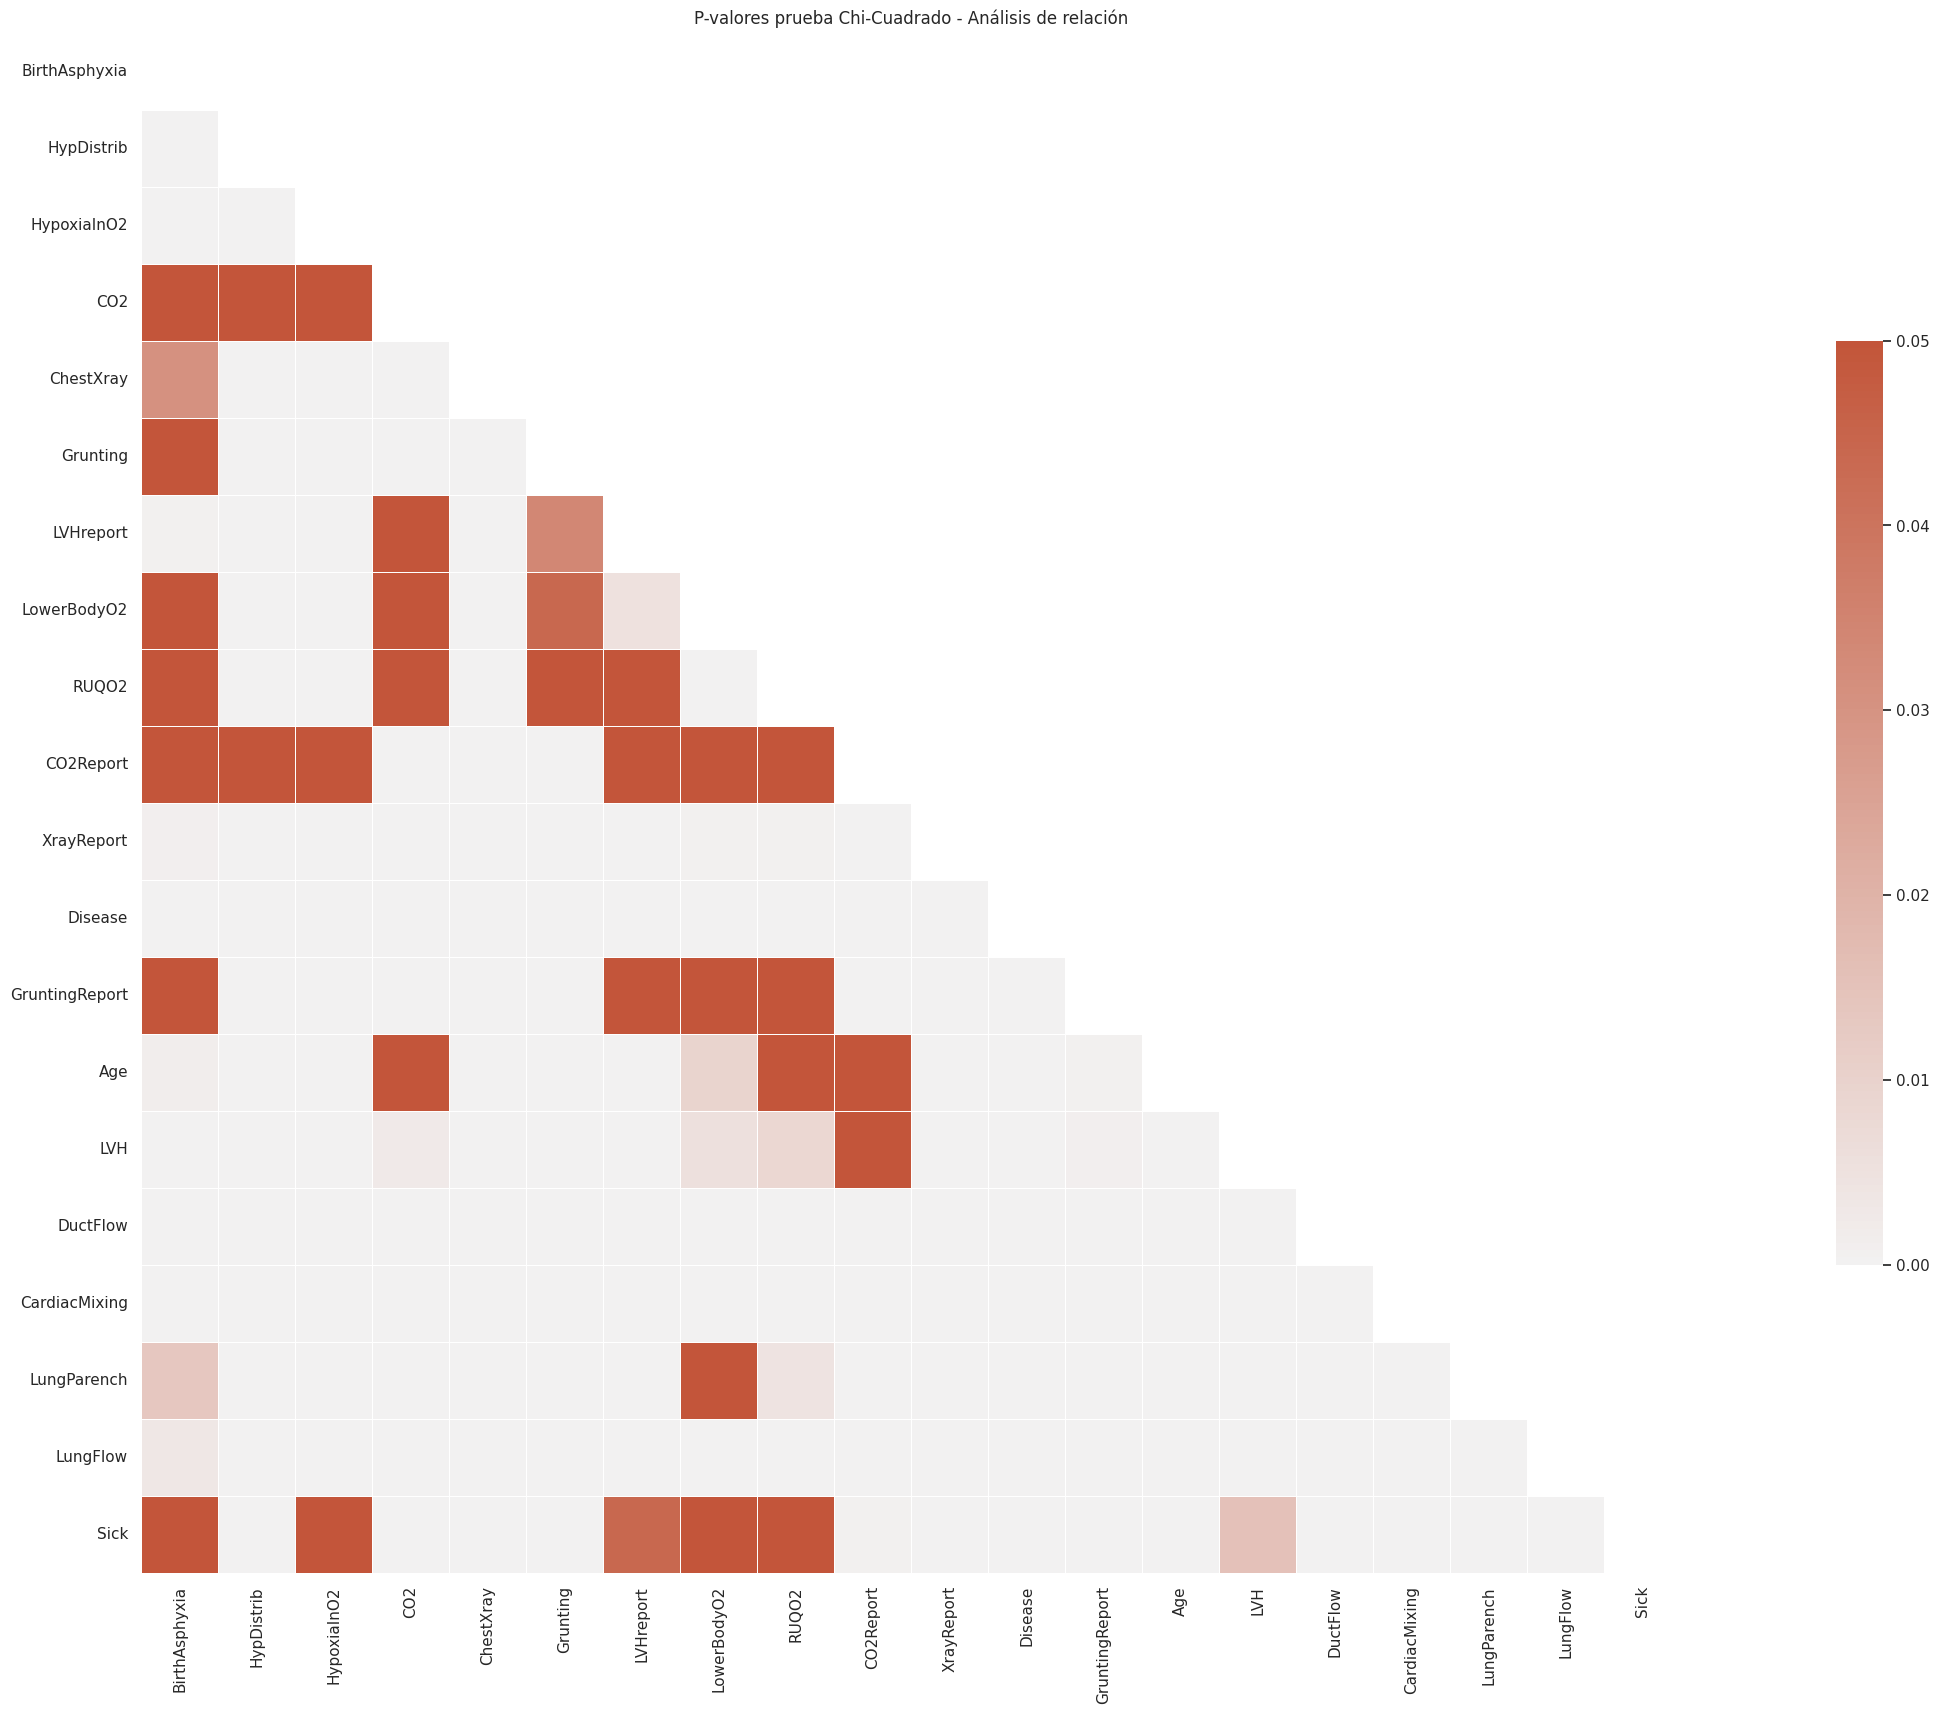

In [ ]:
# Matriz para almacenar los p-valores
p_values_matrix = np.zeros((len(dataframe.columns), len(dataframe.columns)))

for i, columna1 in enumerate(dataframe.columns):
    for j, columna2 in enumerate(dataframe.columns):
      cross_tab = pd.crosstab(dataframe[columna1], dataframe[columna2])
      p_values_matrix[i, j] = chi2_contingency(cross_tab)[1]

# Dataframe de p-valores
p_values_df = pd.DataFrame(p_values_matrix, columns=dataframe.columns, index=dataframe.columns)

# Índices triangular inferior
lower_triangle = np.tril_indices(len(p_values_df), k=-1)

sns.set(style="white")
cmap = sns.diverging_palette(220, 20, as_cmap=True)
fig, ax = plt.subplots(figsize=(2 * len(dataframe.columns), len(dataframe.columns)))

# Mapa de calor de los p-valores
sns.heatmap(p_values_df, mask=np.triu(np.ones_like(p_values_df, dtype=bool)), cmap=cmap, vmax=0.05, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": 0.6})

plt.title('P-valores prueba Chi-Cuadrado - Análisis de relación')
plt.show()

Las casillas rojas oscuro indican que el p-valor es de 0.05 o superior, por lo que se asume independencia entre las variables.

* Información mutua entre las variables:

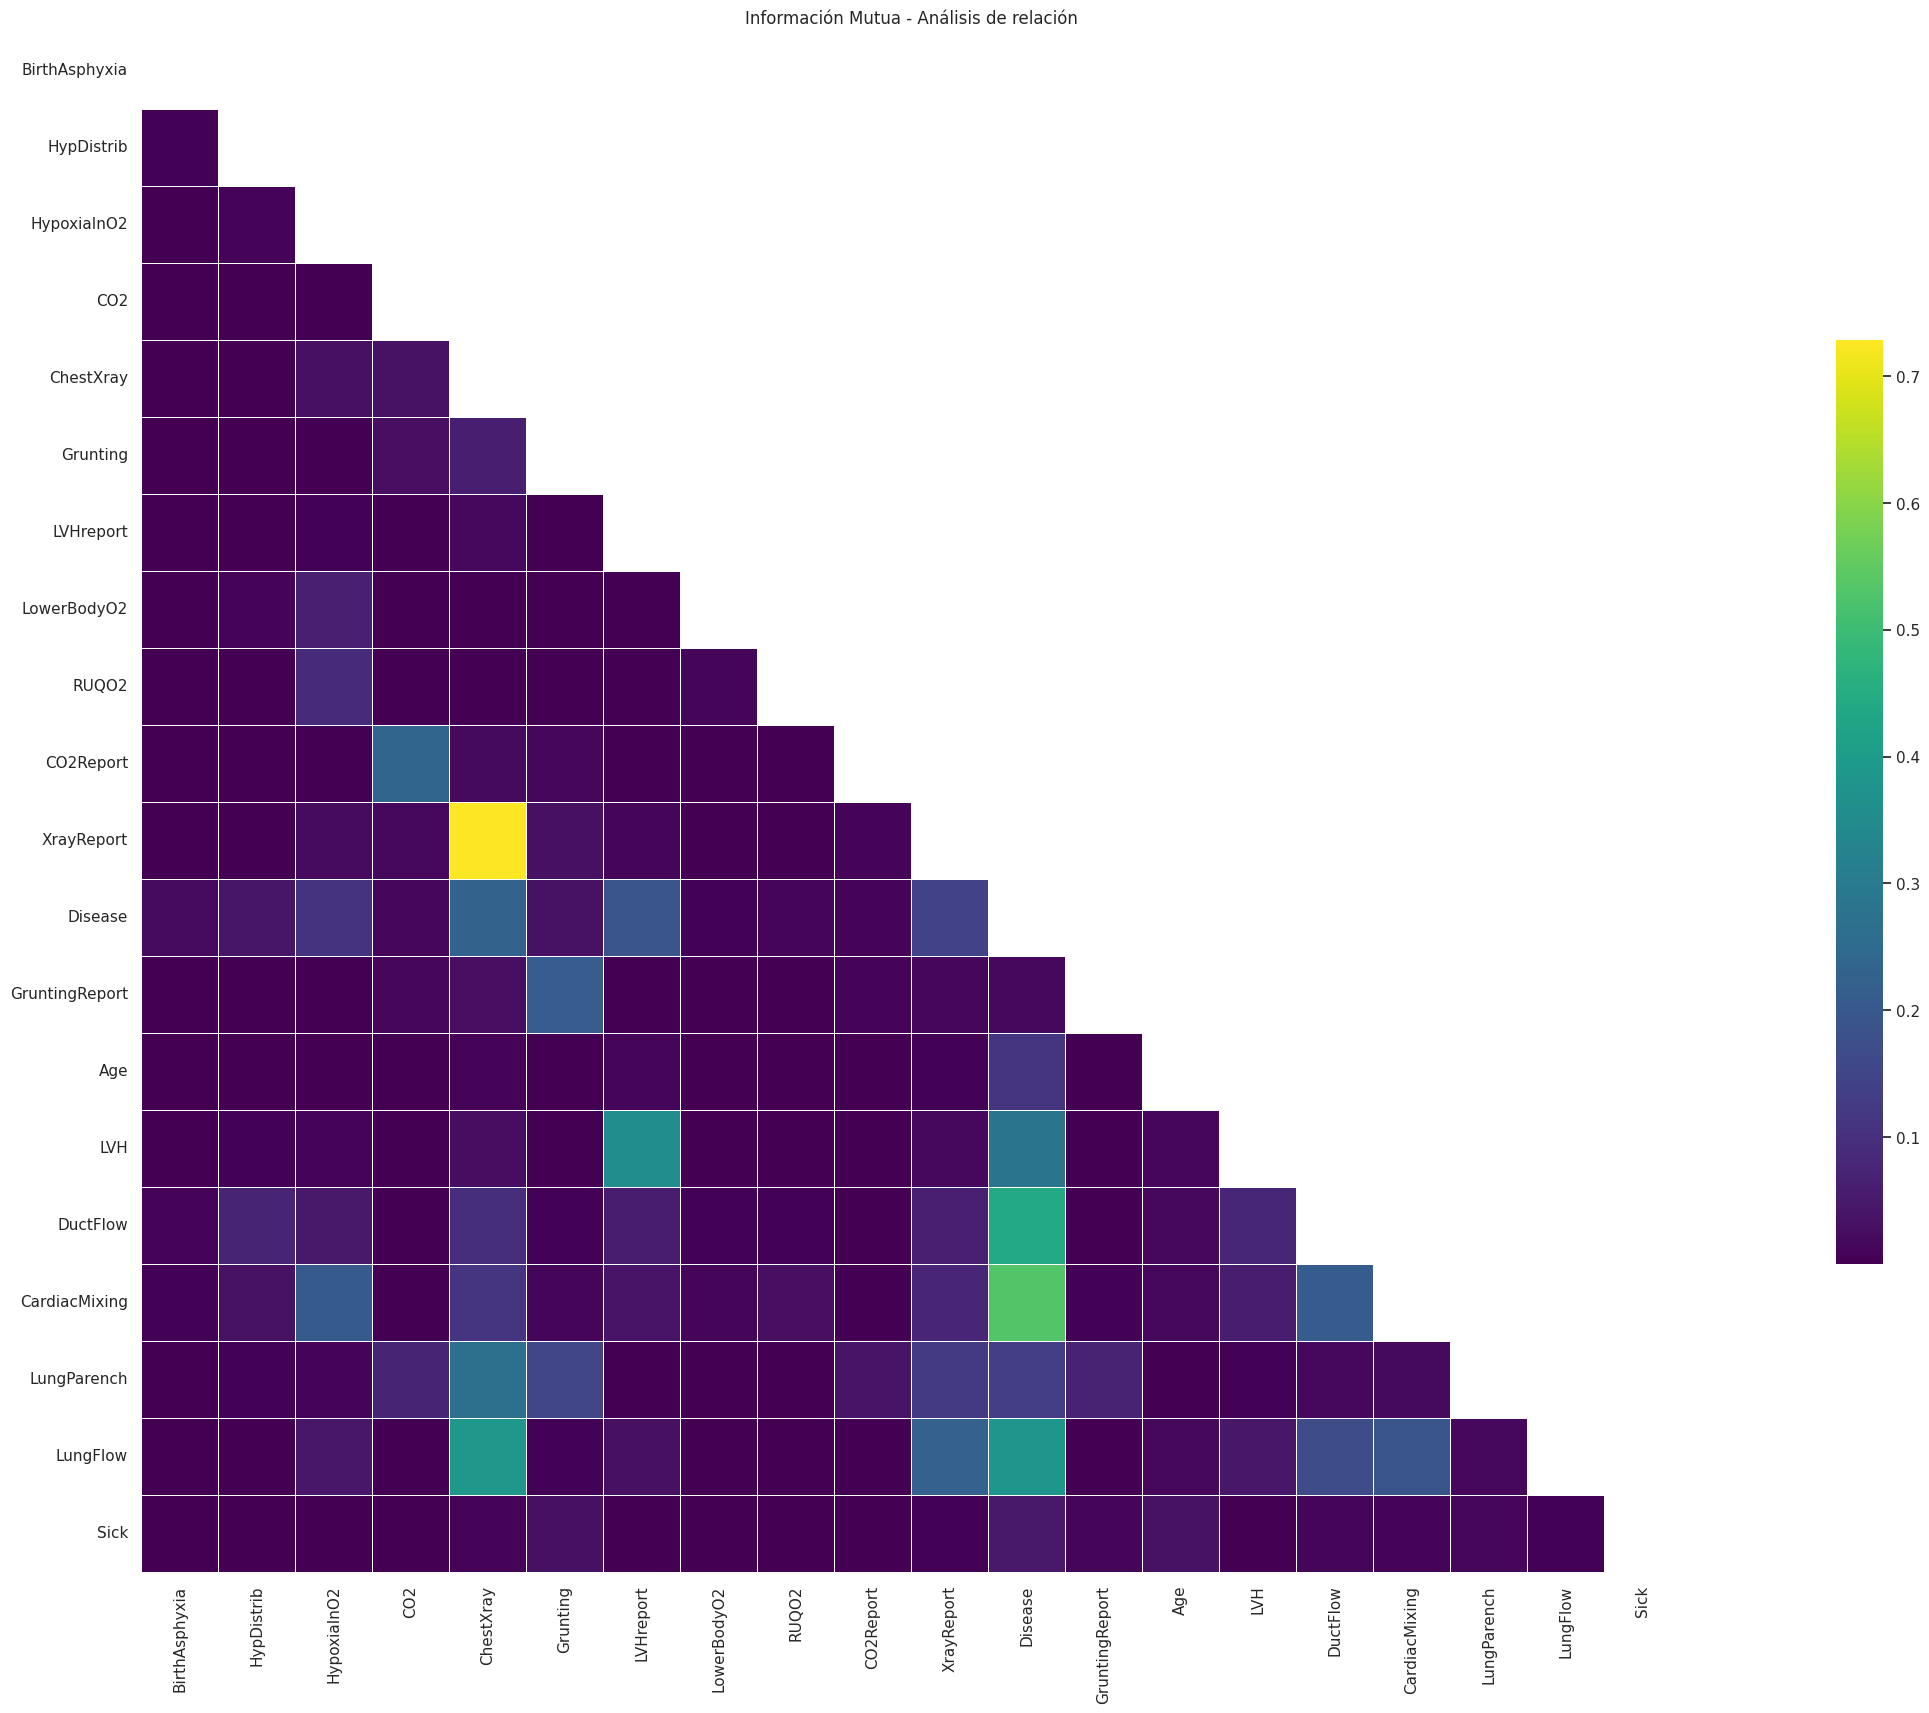

In [ ]:
# Matriz para almacenar la información mutua
mutual_info_matrix = np.zeros((len(dataframe.columns), len(dataframe.columns)))

for i, columna1 in enumerate(dataframe.columns):
    for j, columna2 in enumerate(dataframe.columns):
        p_xy = pd.crosstab(dataframe[columna1], dataframe[columna2]).values / 10000
        # Entropía de las variables individuales
        entropy_x = entropy(p_xy.sum(axis=1))
        entropy_y = entropy(p_xy.sum(axis=0))

        # Entropía conjunta
        joint_entropy = entropy(p_xy.ravel())

        # Información mutua
        mutual_information = entropy_x + entropy_y - joint_entropy
        mutual_info_matrix[i, j] = mutual_information

mutual_info_df = pd.DataFrame(mutual_info_matrix, columns=dataframe.columns, index=dataframe.columns)

lower_triangle = np.tril_indices(len(mutual_info_df), k=-1)


sns.set(style="white")
cmap = sns.color_palette("viridis", as_cmap=True)
fig, ax = plt.subplots(figsize=(2 * len(dataframe.columns), len(dataframe.columns)))

# Mapa de calor de la información mutua
sns.heatmap(mutual_info_df, mask=np.triu(np.ones_like(mutual_info_df, dtype=bool)), cmap=cmap,
            square=True, linewidths=.5, cbar_kws={"shrink": 0.6})
plt.title('Información Mutua - Análisis de relación')
plt.show()

La información mutua es simétrica, y viene definida por la fórmula:
 $$I(X,Y) = H(X) − H(X|Y) = H(Y) - H(Y|X) = H(X) + H(Y) - H(X,Y)$$

 Cuánto mayor sea la información mutua, mayor relación entre las variables. Esto es debido a que si la información mutua es alta, significa que al fijar una de las 2 variables, la entropía de la otra se reduce bastante, por tanto, la dependencia es alta.

 Destaca una alta dependencia entre las variables XRayReport-ChestXRay y CardiacMixing-Disease.

* Análisis Entropía Variables y Entropía Condicionada:

Se representan las entropías de las variables en la diagonal, y en las celdas $[i,j]$, la entropía de la variable i condicionada a la variable j.

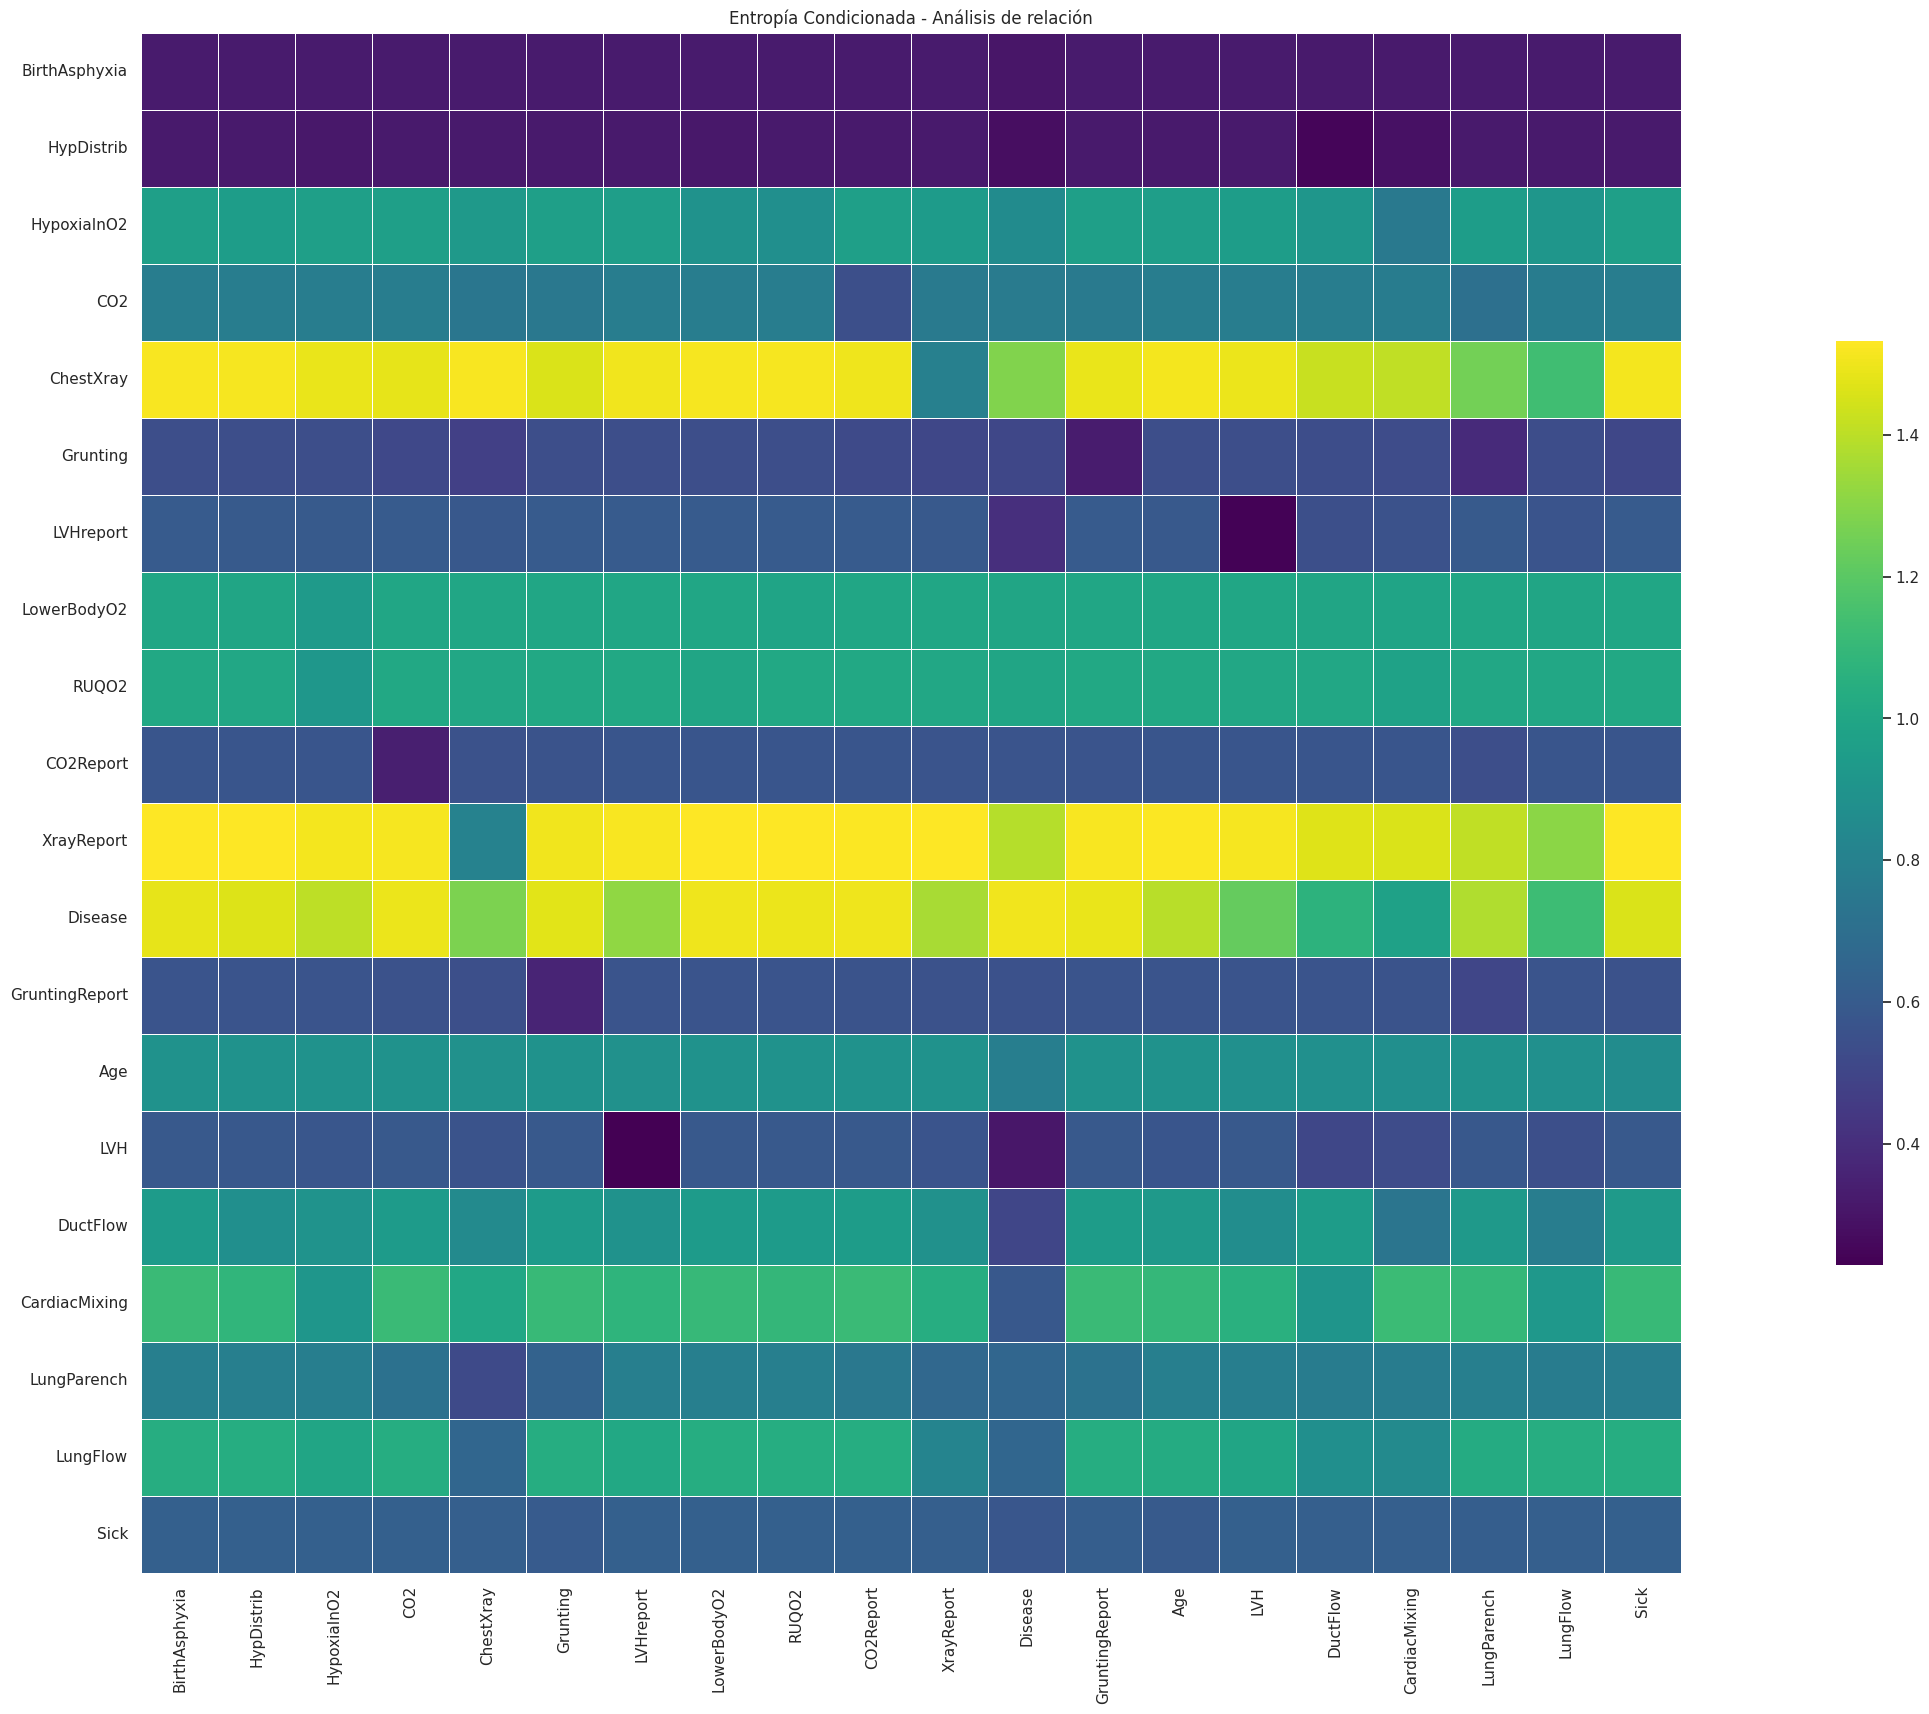

In [ ]:
# Matriz para almacenar las correspondientes entropías
entropy_matrix = np.zeros((len(dataframe.columns), len(dataframe.columns)))

for i, columna1 in enumerate(dataframe.columns):
    for j, columna2 in enumerate(dataframe.columns):
        # Entropía de las variables individuales
        entropy_x = entropy(dataframe[columna1].value_counts(normalize=True))
        entropy_y = entropy(dataframe[columna2].value_counts(normalize=True))
        if columna1 == columna2:
          entropy_matrix[i,j] = entropy_x
        else:
          # Entropía condicionada
          p_xy = pd.crosstab(dataframe[columna1], dataframe[columna2]).values / len(dataframe)
          conditional_entropy = entropy(p_xy.ravel()) - entropy_y
          entropy_matrix[i, j] = conditional_entropy


entropy_df = pd.DataFrame(entropy_matrix, columns=dataframe.columns, index=dataframe.columns)
sns.set(style="white")
cmap = sns.color_palette("viridis", as_cmap=True)
fig, ax = plt.subplots(figsize=(2 * len(dataframe.columns), len(dataframe.columns)))
sns.heatmap(entropy_df, cmap=cmap,
            square=True, linewidths=.5, cbar_kws={"shrink": 0.6})

plt.title('Entropía Condicionada - Análisis de relación')
plt.show()

## Elabora un modelo de red bayesiana aprendiendo estructura y parámetros a partir de los datos (puedes usar cualquier lenguaje o paquete).


Utilizamos el método HillClimbSearch de la librería pgmpy para estimar una estructura. Después se crea el modelo y se ajusta por máxima verosimilitud.

In [ ]:
hc = HillClimbSearch(dataframe)
best_model = hc.estimate(scoring_method=BicScore(dataframe))

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [ ]:
model = BayesianNetwork(best_model.edges())
model.fit(
    data=dataframe,
    estimator=MaximumLikelihoodEstimator
)

## EDA de la red:

* Representa la red
* Indica la factorización asociada, por ejemplo:  $P(A) \cdot P(B|A) \cdot P(C|A,B)$
* ¿Cuántos nodos tiene? ¿Arcos?
* ¿Cuál es el tamaño medio del vecindario?
* ¿Existen estructuras tipo V? ¿Cuáles son?
* ¿Cuáles son los padres de PKA?
* ¿Cuál es el manto de markov de jnk?¿Y su vecindario?
* ¿Las distribuciones son discretas o gausianas?

### REPRESENTACIÓN DE LA RED

In [ ]:
# FUNCION PARA DIBUJAR REDES POR NIVELES
def dibuja_por_niveles(nodos_por_filas, red_bayesiana):
  grafo_dirigido = nx.DiGraph(red_bayesiana.edges())
  len_max = max([len(x) for x in nodos_por_filas])
  pos = {}
  for i, fila in enumerate(nodos_por_filas):
      for j, nodo in enumerate(fila):
          pos[nodo] = (j+(len_max-len(fila))/2, -i)

  plt.figure(figsize=(12, 8))
  nx.draw(grafo_dirigido, pos, with_labels=True, node_size=2500, node_color='skyblue', font_size=7)

  plt.show()

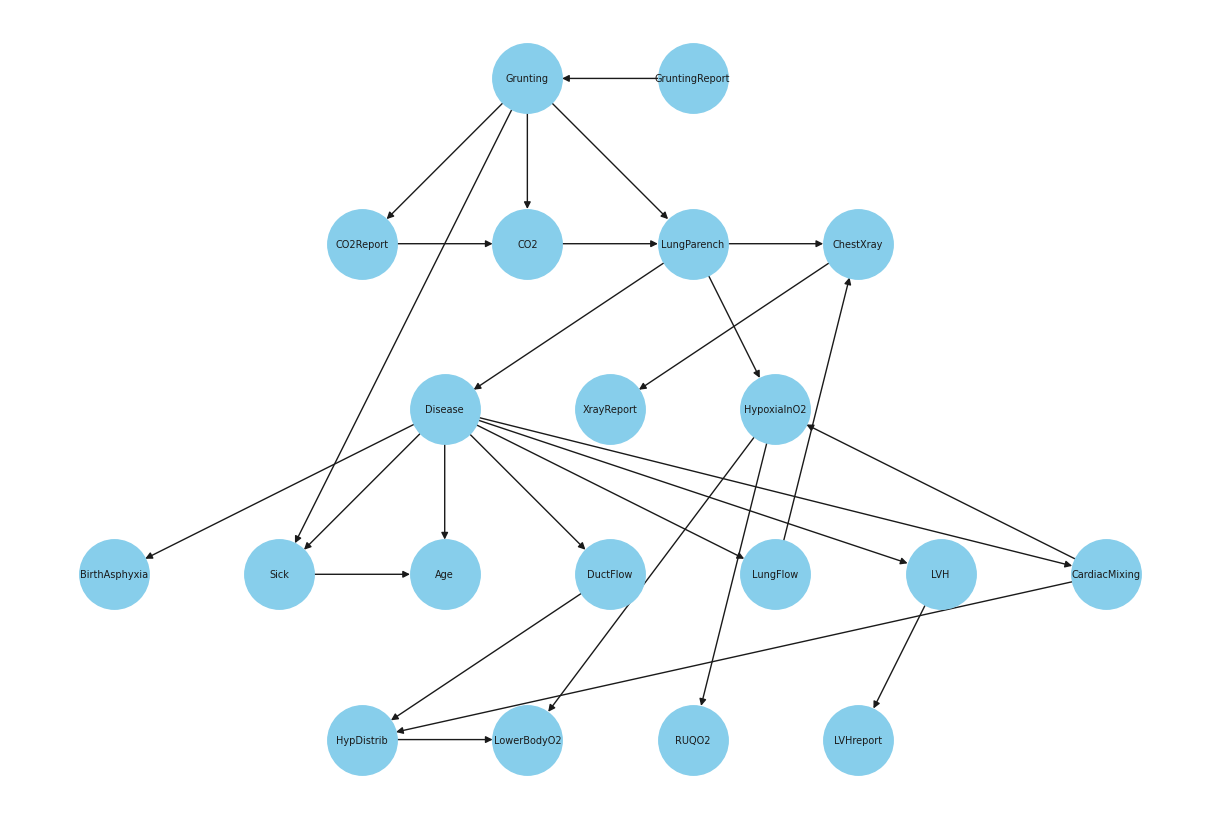

In [ ]:
nodos_por_filas = [
    ['Grunting', 'GruntingReport'],
    ['CO2Report', 'CO2', 'LungParench', 'ChestXray'],
    ['Disease', 'XrayReport', 'HypoxiaInO2'],
    ['BirthAsphyxia', 'Sick', 'Age', 'DuctFlow', 'LungFlow', 'LVH', 'CardiacMixing'],
    ['HypDistrib', 'LowerBodyO2', 'RUQO2', 'LVHreport']
]

dibuja_por_niveles(nodos_por_filas, model)

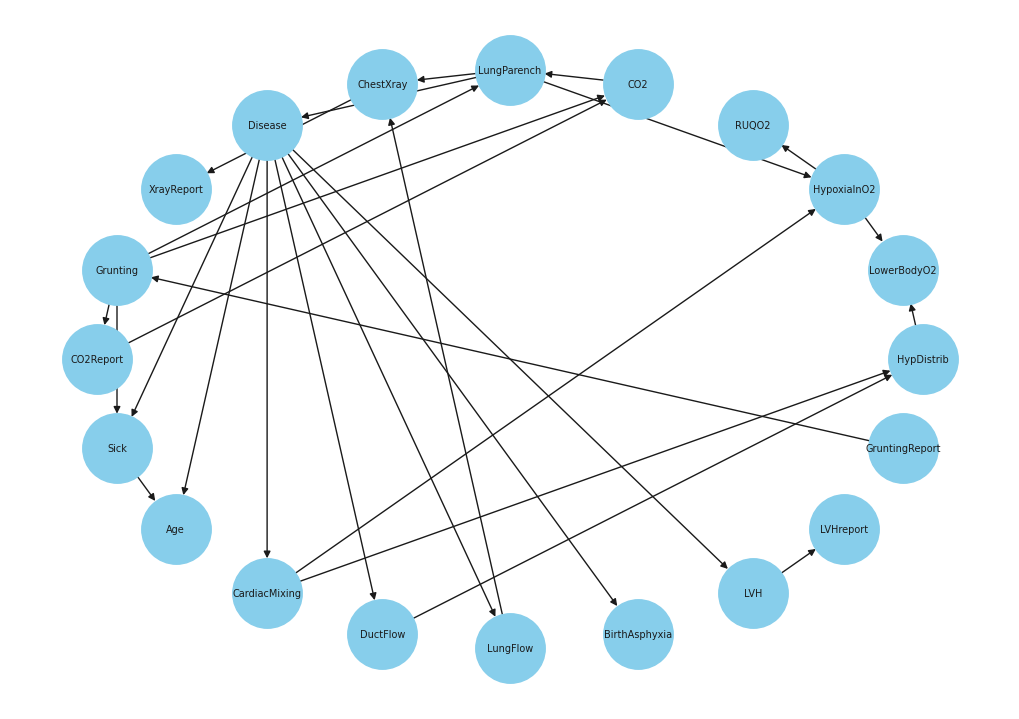

In [ ]:
# REPRESENTACIÓN CIRCULAR
grafo_dirigido = nx.DiGraph(model.edges())
pos = nx.circular_layout(grafo_dirigido)
plt.figure(figsize=(10, 7))
nx.draw(grafo_dirigido, pos, with_labels=True, node_size=2500, node_color='skyblue', font_size=7)
plt.show()

### FACTORIZACIÓN DE LA RED, NÚMERO DE NODOS, NÚMERO DE ARCOS, TAMAÑO MEDIO DE VECINDARIO

In [ ]:
# CREAMOS UNA FUNCIÓN QUE NOS DA LA FACTORIZACIÓN DADO UN MODELO
def dame_factorizacion(model):
  nodos = list(model.nodes())
  arcos = list(model.edges())
  factorizacion = ''
  for nodo in nodos:
    padres = list(model.predecessors(nodo))
    factor = f'P({nodo}'
    if len(padres) > 0:
      factor = factor + '|' + ''.join([x for x in str(padres)[1:-1] if x != "'"])
    factor = factor + ')*'
    factorizacion = factorizacion + factor
  return factorizacion[:-1]

In [ ]:
print(dame_factorizacion(model))

P(HypDistrib|DuctFlow, CardiacMixing)*P(LowerBodyO2|HypDistrib, HypoxiaInO2)*P(HypoxiaInO2|CardiacMixing, LungParench)*P(RUQO2|HypoxiaInO2)*P(CO2|Grunting, CO2Report)*P(LungParench|CO2, Grunting)*P(ChestXray|LungParench, LungFlow)*P(XrayReport|ChestXray)*P(Grunting|GruntingReport)*P(CO2Report|Grunting)*P(Sick|Grunting, Disease)*P(Disease|LungParench)*P(CardiacMixing|Disease)*P(DuctFlow|Disease)*P(LungFlow|Disease)*P(Age|Disease, Sick)*P(BirthAsphyxia|Disease)*P(LVH|Disease)*P(GruntingReport)*P(LVHreport|LVH)


In [ ]:
# NUMERO DE ARCOS Y NODOS
print(f'NÚMERO DE NODOS: {len(model.nodes())}')
print(f'NÚMERO DE ARCOS: {len(model.edges())}')

NÚMERO DE NODOS: 20
NÚMERO DE ARCOS: 27


In [ ]:
# SOBRE VECINDARIO
print(f'NÚMERO MEDIO DE PADRES: {np.mean( [len(list(model.predecessors(nodo))) for nodo in model.nodes()] )}')
print(f'NÚMERO MEDIO DE HIJOS: {np.mean( [len(list(model.get_children(nodo))) for nodo in model.nodes()] )}')
print(f'NÚMERO MEDIO DEL VECINDARIO: {np.mean( [len(list(model.predecessors(nodo)))+len(list(model.get_children(nodo))) for nodo in model.nodes()] )}')

NÚMERO MEDIO DE PADRES: 1.35
NÚMERO MEDIO DE HIJOS: 1.35
NÚMERO MEDIO DEL VECINDARIO: 2.7


### ESTRUCTURAS HEAD-TO-HEAD (TIPO V)

In [ ]:
padres_head_to_head = list(model.get_immoralities()) # DEVUELVE LOS PARES HEAD DE LA ESTRUCTURA HEAD-TO-HEAD
estructuras_head_to_head = []
for p1, p2 in padres_head_to_head:
  hijos1 = set(model.get_children(p1))
  hijos2 = set(model.get_children(p2))
  for h in hijos1 & hijos2: # INTERSECCION
    estructuras_head_to_head.append(f'{p1}->{h}<-{p2}')

print('ESTRUCTURAS HEAD-TO-HEAD padre1 -> hijo <- padre2:')
for hth in estructuras_head_to_head:
  print(hth)

ESTRUCTURAS HEAD-TO-HEAD padre1 -> hijo <- padre2:
LungFlow->ChestXray<-LungParench
CardiacMixing->HypDistrib<-DuctFlow
CardiacMixing->HypoxiaInO2<-LungParench
HypDistrib->LowerBodyO2<-HypoxiaInO2
Disease->Sick<-Grunting


### ¿PADRES DE PKA?¿MANTO DE MARKOV DE jnk?¿VECINDARIO?
Como PKA y jnk no son variables de nuestro modelo, consideraremos la variable Disease.

In [ ]:
var = 'Disease' # (Cambiar para elegir la variable)
# PADRES
print(f'PADRES DE {var}: {list(model.predecessors(var))}')
# MANTO DE MARKOV
print(f'MANTO DE MARKOV DE {var}: {model.get_markov_blanket(var)}')
# VECINDARIO
print(f'VECINDARIO DE {var}: {list(model.predecessors(var)) + list(model.get_children(var))}')

PADRES DE Disease: ['LungParench']
MANTO DE MARKOV DE Disease: ['LVH', 'CardiacMixing', 'LungParench', 'BirthAsphyxia', 'Grunting', 'Sick', 'DuctFlow', 'LungFlow', 'Age']
VECINDARIO DE Disease: ['LungParench', 'CardiacMixing', 'DuctFlow', 'LungFlow', 'Age', 'Sick', 'BirthAsphyxia', 'LVH']


### ¿DISTRIBUCIONES DISCRETAS O CONTINUAS?
**Todas las variables de las que se disponen son discretas** si bien es cierto que **algunas** como 'LowerBodyO2' o 'Age' **han sido discretizadas**.

## Importa la red original (construida a partir de los datos y conocimiento experto) que describen en el paper utilizando cualquiera de los ficheros que se adjuntan (extensiones: .bib, .dsc, .net, .RDA (bn.fit), .RDS (bn.fit) ). Compara la salida anterior con esta nueva red.

* Represéntalas
* ¿Qué diferencias observas? Mide la distancia estructural. ¿Son redes equivalentes, l-map (salvo cambios de direcciones)?
* ¿Cuál te parece más interesante y por qué?
* ¿Cuál tiene mejor puntuación sobre los datos cargados?

### CARGAMOS LA RED

In [ ]:
root = "/content/child.bif.gz"
with gzip.open(root, 'rt') as archivo_gz:
    contenido = archivo_gz.read()
lector_bif = BIFReader(string=contenido)
child = lector_bif.get_model()

### REPRESENTACIÓN DE LA RED

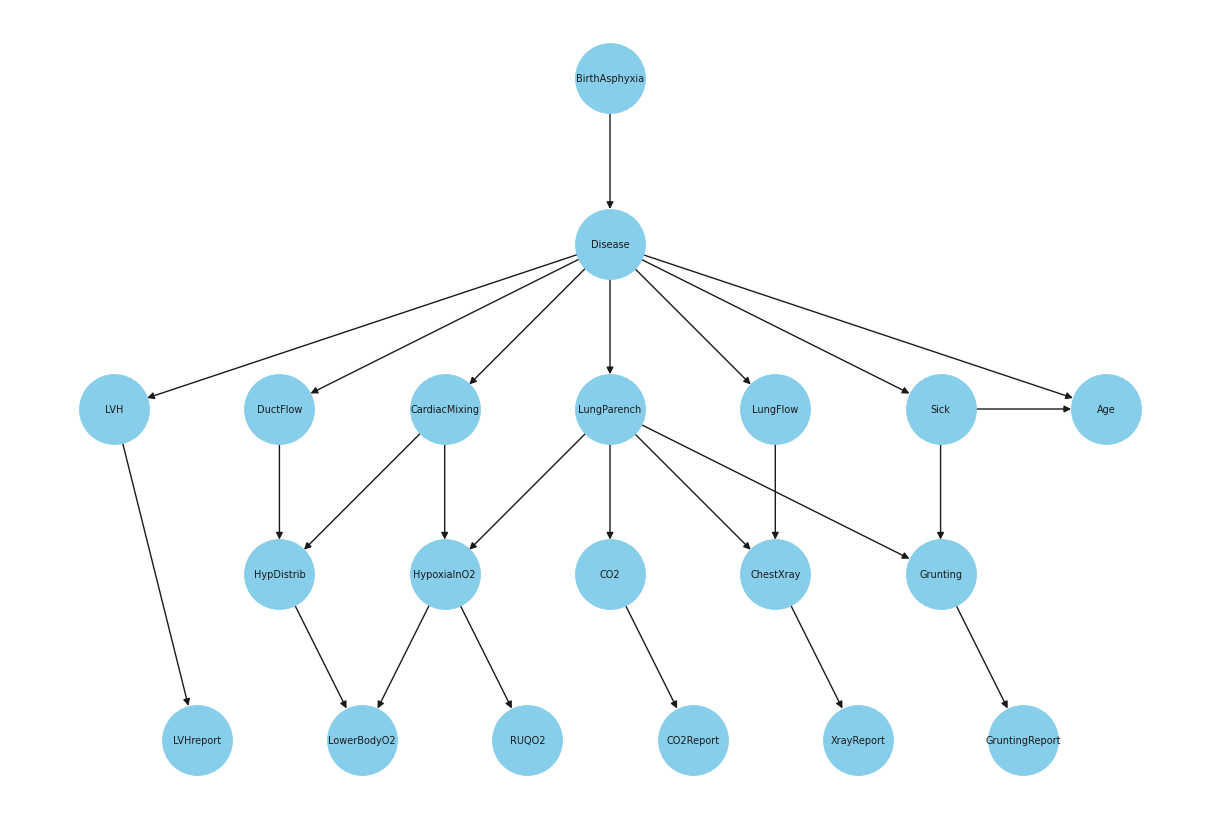

In [ ]:
nodos_por_filas = [
    ['BirthAsphyxia'],
    ['Disease'],
    ['LVH', 'DuctFlow', 'CardiacMixing', 'LungParench', 'LungFlow', 'Sick', 'Age'],
    ['HypDistrib', 'HypoxiaInO2', 'CO2', 'ChestXray', 'Grunting'],
    ['LVHreport', 'LowerBodyO2', 'RUQO2', 'CO2Report', 'XrayReport', 'GruntingReport']
]

dibuja_por_niveles(nodos_por_filas, child)

### DIFERENCIAS ENTRE LAS REDES. ¿DISTANCIA ESTRUCTURAL? ¿SON EQUIVALENTES?

Ambas redes se parecen en cuanto a que Disease tiene practicamente los mismos nodos hijo representando la relación de la enfermedad con esas variables. Incluso, aunque LungParench sea padre de Disease en ''model'' en vez de al revés como en ''child'', se captura en ambas esa dependencia y la de LungParench con CO2 y Grunting. En complejidad también se parecen al tener una cantidad muy similar de arcos. Sin embargo, ''child'' parece tener cierta noción de causalidad y posee una estructura más interpretable.

Para medir la distancia estructural podemos calcular la Distancia Estructural de Hamming (SHD por sus siglas en inglés). Es una medida estándar para comparar grafos mediante sus matrices de adyacencia. Cada arista que esté ausente o no esté en el grafo objetivo se cuenta como un error. Es importante tener en cuenta que para grafos dirigidos, dos errores pueden ser contados, ya que la arista en la dirección incorrecta se considera un error y la arista en la dirección correcta que falta también se cuenta como un error. El argumento double_for_anticausal tiene en cuenta esta observación. Establecerlo en False contará esto como un solo error.

In [ ]:
# NUMERO DE ARCOS Y NODOS
print(f'NÚMERO DE NODOS: {len(child.nodes())}')
print(f'NÚMERO DE ARCOS: {len(child.edges())}')

# SOBRE VECINDARIO
print(f'NÚMERO MEDIO DE PADRES: {np.mean( [len(list(child.predecessors(nodo))) for nodo in child.nodes()] )}')
print(f'NÚMERO MEDIO DE HIJOS: {np.mean( [len(list(child.get_children(nodo))) for nodo in child.nodes()] )}')
print(f'NÚMERO MEDIO DEL VECINDARIO: {np.mean( [len(list(child.predecessors(nodo)))+len(list(child.get_children(nodo))) for nodo in child.nodes()] )}')

NÚMERO DE NODOS: 20
NÚMERO DE ARCOS: 25
NÚMERO MEDIO DE PADRES: 1.25
NÚMERO MEDIO DE HIJOS: 1.25
NÚMERO MEDIO DEL VECINDARIO: 2.5


In [ ]:
# DISTANCIA ESTRUCTURAL DE HAMMING
red_model=nx.DiGraph(model.edges())
red_child=nx.DiGraph(child.edges())
cdt.metrics.SHD(red_model, red_child, double_for_anticausal=False)

9.0

In [ ]:
# I-EQUIVALENTES
model.is_iequivalent(child)

False

* No son I-equivalentes

### ¿QUÉ RED ES MÁS INTERESANTE?¿CUÁL TIENE MEJOR PUNTUACIÓN?

In [ ]:
# SCORE BASADO EN BIC DE LA ESTRUCTURA DE LOS MODELOS
score1 = structure_score(model, dataframe, scoring_method ='bic')
score2 = structure_score(child, dataframe, scoring_method ='bic')
print(f'SCORE BASADO EN BIC DEL MODELO CREADO: {score1}')
print(f'SCORE BASADO EN BIC DEL MODELO ORIGINAL child: {score2}')

SCORE BASADO EN BIC DEL MODELO CREADO: -123485.9878138259
SCORE BASADO EN BIC DEL MODELO ORIGINAL child: -123371.48203684758


In [ ]:
# SCORE K2 DE LA ESTRUCTURA DE LOS MODELOS
score1 = structure_score(model, dataframe, scoring_method ='k2')
score2 = structure_score(child, dataframe, scoring_method ='k2')
print(f'SCORE K2 DEL MODELO CREADO: {score1}')
print(f'SCORE K2 DEL MODELO ORIGINAL child: {score2}')

SCORE K2 DEL MODELO CREADO: -123199.11184442042
SCORE K2 DEL MODELO ORIGINAL child: -123103.7706313275


In [ ]:
# LOG VEROSIMILITUD DE LOS MODELOS CON PARÁMETROS AJUSTADOS
print(f'LOG VEROSIMILITUD DEL MODELO CREADO: {log_likelihood_score(model, dataframe)}')
print(f'LOG VEROSIMILITUD DEL MODELO ORIGINAL child: {log_likelihood_score(child, dataframe)}')

LOG VEROSIMILITUD DEL MODELO CREADO: -122371.53662881676
LOG VEROSIMILITUD DEL MODELO ORIGINAL child: -122423.53556970225


El objetivo, según se presenta en el artículo de referencia, es predecir Disease conocidas el resto de variables. Para ello, podríamos plantear cuál es la tasa de aciertos (accuracy) tomando como predicción la categoría de Disease con mayor probabilidad a posteriori. Por esto, tomamos como puntuación el accuracy.

In [ ]:
# ACCURACY PARA child
X = dataframe.drop(columns=['Disease'])
y = dataframe['Disease'].values
preds = child.predict(X, stochastic =True) # Por muestreo para tardar menos
preds = np.squeeze(preds.values)
accuracy_child = sum(y==preds)/len(y)
print(f'ACCURACY DEL MODELO child: {accuracy_child}')

  0%|          | 0/7940 [00:00<?, ?it/s]

ACCURACY DEL MODELO child: 0.836


In [ ]:
# ACCURACY PARA model
preds = model.predict(X, stochastic =True) # Por muestreo para tardar menos
preds = np.squeeze(preds.values)
accuracy_model = sum(y==preds)/len(y)
print(f'ACCURACY DEL MODELO model: {accuracy_model}')

  0%|          | 0/7940 [00:00<?, ?it/s]

ACCURACY DEL MODELO model: 0.8333


Para las métricas BIC y K2, child tiene un score mayor que el modelo que hemos obtenido. El accuracy es muy similar. Por otro lado, model tiene una mayor log verosimilitud indicando que se ajusta más a los datos, sin embargo, esto podría deberse a un sobreajuste de la muestra, por ello es aconsejable comparar modelos con validación cruzada como veremos en el siguiente apartado. De todos modos, el modelo child resulta más interesante al ser menos complejo en cuanto a número de aristas (solo 2 menos que model) conservando buena puntuación frente a model, además tiene cierta noción de causalidad el DAG asociado lo que puede facilitar su interpretabilidad.

## Mejora del aprendizaje:

* Prueba distintas opciones del algoritmo (por ejemplo otros scores)
* Prueba otros algoritmos
* Discretiza la variable (tenéis un dataset discretizado también), utilizando discretize (en R)
* Explora la posibilidad de hacer un boosting de varios modelos (boot.strength y averaged.network en R)
* ¿Cuál se asemeja más al original?
* ¿Cuál tiene mejor resultado en validación cruzada?

### Prueba distintas opciones del algoritmo:
Se han probado otros scores para el aprendizaje de la estructura, y otro estimador para los parámetros, como el estimador Bayesiano.



In [ ]:
# Estimador Bayesiano parámetros y basado en Bic Score para estimar la estructura

hc = HillClimbSearch(dataframe)
best_model = hc.estimate(scoring_method=BicScore(dataframe))
print(best_model.edges())

model_bic_bay = BayesianNetwork(ebunch=best_model.edges())
model_bic_bay.fit(
    data=dataframe,
    estimator=BayesianEstimator,
)

score_bic = structure_score(model_bic_bay, dataframe, scoring_method ='bic')

print(f'Score BIC modelo estimado: {score_bic}')

score_k2 = structure_score(model_bic_bay, dataframe, scoring_method ='k2')

print(f'Score K2 modelo estimado: {score_k2}')

print(f'Log Verosimilitud del modelo estimado:  {log_likelihood_score(model_bic_bay, dataframe)}')

red_model=nx.DiGraph(model_bic_bay.edges())

print(f'Distancia Hamming con modelo child: {cdt.metrics.SHD(red_model, red_child, double_for_anticausal=False)}')

  0%|          | 0/1000000 [00:00<?, ?it/s]

[('HypDistrib', 'LowerBodyO2'), ('HypoxiaInO2', 'RUQO2'), ('HypoxiaInO2', 'LowerBodyO2'), ('CO2', 'LungParench'), ('ChestXray', 'XrayReport'), ('Grunting', 'LungParench'), ('Grunting', 'CO2Report'), ('Grunting', 'Sick'), ('Grunting', 'CO2'), ('CO2Report', 'CO2'), ('Disease', 'CardiacMixing'), ('Disease', 'DuctFlow'), ('Disease', 'LungFlow'), ('Disease', 'Age'), ('Disease', 'Sick'), ('Disease', 'BirthAsphyxia'), ('Disease', 'LVH'), ('GruntingReport', 'Grunting'), ('LVH', 'LVHreport'), ('DuctFlow', 'HypDistrib'), ('CardiacMixing', 'HypoxiaInO2'), ('CardiacMixing', 'HypDistrib'), ('LungParench', 'ChestXray'), ('LungParench', 'Disease'), ('LungParench', 'HypoxiaInO2'), ('LungFlow', 'ChestXray'), ('Sick', 'Age')]
Score BIC modelo estimado: -123485.9878138259
Score K2 modelo estimado: -123199.11184442042
Log Verosimilitud del modelo estimado:  -122372.47047335183
Distancia Hamming con modelo child: 9.0


In [ ]:
# Estimador Maxima Verosimilitud parámetros y basado en K2 Score para estimar la estructura

hc = HillClimbSearch(dataframe)
best_model = hc.estimate(scoring_method=K2Score(dataframe))
print(best_model.edges())

model_k2 = BayesianNetwork(ebunch=best_model.edges())
model_k2.fit(
    data=dataframe,
    estimator=MaximumLikelihoodEstimator,
)

score_bic = structure_score(model_k2, dataframe, scoring_method ='bic')

print(f'Score BIC modelo estimado: {score_bic}')

score_k2 = structure_score(model_k2, dataframe, scoring_method ='k2')

print(f'Score K2 modelo estimado: {score_k2}')

print(f'Log Verosimilitud del modelo estimado:  {log_likelihood_score(model_k2, dataframe)}')

red_model=nx.DiGraph(model_k2.edges())

print(f'Distancia Hamming con modelo real: {cdt.metrics.SHD(red_model, red_child, double_for_anticausal=False)}')

  0%|          | 0/1000000 [00:00<?, ?it/s]

[('HypDistrib', 'LowerBodyO2'), ('HypoxiaInO2', 'RUQO2'), ('HypoxiaInO2', 'LowerBodyO2'), ('CO2', 'CO2Report'), ('ChestXray', 'XrayReport'), ('Grunting', 'GruntingReport'), ('Disease', 'DuctFlow'), ('Disease', 'LungFlow'), ('Disease', 'LVH'), ('Disease', 'LungParench'), ('Disease', 'Age'), ('Disease', 'Sick'), ('Disease', 'BirthAsphyxia'), ('Age', 'Sick'), ('LVH', 'LVHreport'), ('DuctFlow', 'HypDistrib'), ('CardiacMixing', 'Disease'), ('CardiacMixing', 'HypoxiaInO2'), ('CardiacMixing', 'HypDistrib'), ('LungParench', 'ChestXray'), ('LungParench', 'Grunting'), ('LungParench', 'CO2'), ('LungParench', 'HypoxiaInO2'), ('LungFlow', 'ChestXray'), ('Sick', 'Grunting')]
Score BIC modelo estimado: -123371.48203684755
Score K2 modelo estimado: -123100.57717710536
Log Verosimilitud del modelo estimado:  -122312.29289407028
Distancia Hamming con modelo real: 3.0


In [ ]:
# Estimador Maxima Verosimilitud parámetros y basado en BDeu Score para estimar la estructura

best_model = hc.estimate(scoring_method=BDeuScore(dataframe))
print(best_model.edges())

model_bd = BayesianNetwork(ebunch=best_model.edges())
model_bd.fit(
    data=dataframe,
    estimator=MaximumLikelihoodEstimator,
)

score_bic = structure_score(model_bd, dataframe, scoring_method ='bic')

print(f'Score BIC modelo estimado: {score_bic}')

score_k2 = structure_score(model_bd, dataframe, scoring_method ='k2')

print(f'Score K2 modelo estimado: {score_k2}')

print(f'Log Verosimilitud del modelo estimado: {log_likelihood_score(model_bd, dataframe)}')

red_model=nx.DiGraph(model_bd.edges())

print(f'Distancia Hamming con modelo real: {cdt.metrics.SHD(red_model, red_child, double_for_anticausal=False)}')

  0%|          | 0/1000000 [00:00<?, ?it/s]

[('HypDistrib', 'LowerBodyO2'), ('HypoxiaInO2', 'RUQO2'), ('HypoxiaInO2', 'LowerBodyO2'), ('CO2', 'CO2Report'), ('ChestXray', 'LungFlow'), ('ChestXray', 'LungParench'), ('ChestXray', 'Grunting'), ('Grunting', 'LungParench'), ('Grunting', 'GruntingReport'), ('Grunting', 'Sick'), ('LVHreport', 'LVH'), ('XrayReport', 'ChestXray'), ('Disease', 'CardiacMixing'), ('Disease', 'LVHreport'), ('Disease', 'DuctFlow'), ('Disease', 'Age'), ('Disease', 'LVH'), ('Disease', 'Sick'), ('Disease', 'BirthAsphyxia'), ('DuctFlow', 'HypDistrib'), ('CardiacMixing', 'HypoxiaInO2'), ('CardiacMixing', 'HypDistrib'), ('LungParench', 'Disease'), ('LungParench', 'LungFlow'), ('LungParench', 'CO2'), ('LungParench', 'HypoxiaInO2'), ('LungFlow', 'Disease'), ('Sick', 'Age')]
Score BIC modelo estimado: -123638.8658263656
Score K2 modelo estimado: -123287.26109091255
Log Verosimilitud del modelo estimado: -122354.0233444749
Distancia Hamming con modelo real: 12.0


In [ ]:
# Estimador Bayesiano de Parámetros y basado en K2 Score para estimar la estructura

hc = HillClimbSearch(dataframe)
best_model = hc.estimate(scoring_method=K2Score(dataframe))
print(best_model.edges())

model_k2_bay = BayesianNetwork(ebunch=best_model.edges())
model_k2_bay.fit(
    data=dataframe,
    estimator=BayesianEstimator,
)

score_bic = structure_score(model_k2_bay, dataframe, scoring_method ='bic')

print(f'Score BIC modelo estimado: {score_bic}')

score_k2 = structure_score(model_k2_bay, dataframe, scoring_method ='k2')

print(f'Score K2 modelo estimado: {score_k2}')

print(f'Log Verosimilitud del modelo estimado: {log_likelihood_score(model_k2_bay, dataframe)}')

red_model=nx.DiGraph(model_k2_bay.edges())

print(f'Distancia Hamming con modelo real: {cdt.metrics.SHD(red_model, red_child, double_for_anticausal=False)}')

  0%|          | 0/1000000 [00:00<?, ?it/s]

[('HypDistrib', 'LowerBodyO2'), ('HypoxiaInO2', 'RUQO2'), ('HypoxiaInO2', 'LowerBodyO2'), ('CO2', 'CO2Report'), ('ChestXray', 'XrayReport'), ('Grunting', 'GruntingReport'), ('Disease', 'DuctFlow'), ('Disease', 'LungFlow'), ('Disease', 'LVH'), ('Disease', 'LungParench'), ('Disease', 'Age'), ('Disease', 'Sick'), ('Disease', 'BirthAsphyxia'), ('Age', 'Sick'), ('LVH', 'LVHreport'), ('DuctFlow', 'HypDistrib'), ('CardiacMixing', 'Disease'), ('CardiacMixing', 'HypoxiaInO2'), ('CardiacMixing', 'HypDistrib'), ('LungParench', 'ChestXray'), ('LungParench', 'Grunting'), ('LungParench', 'CO2'), ('LungParench', 'HypoxiaInO2'), ('LungFlow', 'ChestXray'), ('Sick', 'Grunting')]
Score BIC modelo estimado: -123371.48203684755
Score K2 modelo estimado: -123100.57717710536
Log Verosimilitud del modelo estimado: -122313.22474624935
Distancia Hamming con modelo real: 3.0


In [ ]:
# Estimador Bayesiano de Parámetros y basado en BDeu Score para estimar la estructura

best_model = hc.estimate(scoring_method=BDeuScore(dataframe))
print(best_model.edges())

model_bd_bay = BayesianNetwork(ebunch=best_model.edges())
model_bd_bay.fit(
    data=dataframe,
    estimator=BayesianEstimator,
)

score_bic = structure_score(model_bd_bay, dataframe, scoring_method ='bic')

print(f'Score BIC modelo estimado: {score_bic}')

score_k2 = structure_score(model_bd_bay, dataframe, scoring_method ='k2')

print(f'Score K2 modelo estimado: {score_k2}')

print(f'Log Verosimilitud del modelo estimado: {log_likelihood_score(model_bd_bay, dataframe)}')

red_model=nx.DiGraph(model_bd_bay.edges())

print(f'Distancia Hamming con modelo real: {cdt.metrics.SHD(red_model, red_child, double_for_anticausal=False)}')


  0%|          | 0/1000000 [00:00<?, ?it/s]

[('HypDistrib', 'LowerBodyO2'), ('HypoxiaInO2', 'RUQO2'), ('HypoxiaInO2', 'LowerBodyO2'), ('CO2', 'CO2Report'), ('ChestXray', 'LungFlow'), ('ChestXray', 'LungParench'), ('ChestXray', 'Grunting'), ('Grunting', 'LungParench'), ('Grunting', 'GruntingReport'), ('Grunting', 'Sick'), ('LVHreport', 'LVH'), ('XrayReport', 'ChestXray'), ('Disease', 'CardiacMixing'), ('Disease', 'LVHreport'), ('Disease', 'DuctFlow'), ('Disease', 'Age'), ('Disease', 'LVH'), ('Disease', 'Sick'), ('Disease', 'BirthAsphyxia'), ('DuctFlow', 'HypDistrib'), ('CardiacMixing', 'HypoxiaInO2'), ('CardiacMixing', 'HypDistrib'), ('LungParench', 'Disease'), ('LungParench', 'LungFlow'), ('LungParench', 'CO2'), ('LungParench', 'HypoxiaInO2'), ('LungFlow', 'Disease'), ('Sick', 'Age')]
Score BIC modelo estimado: -123638.8658263656
Score K2 modelo estimado: -123287.26109091255
Log Verosimilitud del modelo estimado: -122355.09143833777
Distancia Hamming con modelo real: 12.0


### Prueba otros algoritmos

Los métodos probados anteriormente están basados en una función de score para aprender la estructura de la red. Además, solo se ha usado el método HillClimb, y no la Busqueda Exhaustiva, debido al gran número de nodos.

Veamos ahora algunos algoritmos basados en contrastes de hipótesis, como el algoritmo PC:

Con un método para realizar pruebas de independencia en mano, podemos construir un DAG a partir del conjunto de datos en tres pasos:
1. Construir un esqueleto no dirigido
2. Orientar las aristas para obtener un grafo acíclico parcialmente dirigido
3. Extender el patrón DAG a un DAG orientando conservado las aristas restantes de alguna manera - pdag_to_dag()

Los pasos 1 y 2 conforman el llamado algoritmo PC. Se pueden usar distintos test para evaluar la independencia, y con distintos niveles de significación en este algoritmo, como el de chi-cuadrado, freeman_tuckey, g_sq, neyman, parson, log-verosimilitud...

En este caso, se usará el estadístico chi-cuadrado para estimar los modelos en primer lugar, y la log-verosimilitud.

In [ ]:
## TEST CHI-CUADRADO

est = PC(dataframe)

'''
skel, seperating_sets = est.build_skeleton(ci_test = 'chi_square')
print("Undirected edges: ", skel.edges())

pdag = est.skeleton_to_pdag(skel, seperating_sets)
print("PDAG edges:       ", pdag.edges())

dag = pdag.to_dag()
print("DAG edges:        ", dag.edges())
'''
#Para hacerlo directamente:
model_pc = est.estimate(ci_test = 'chi_square', return_type="dag",variant = 'stable') #variant stable para quitar aleatoriedad

  0%|          | 0/5 [00:00<?, ?it/s]

In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to 

In [ ]:
print(model_pc.edges())
# FILTRO EL DATAFRAME CON LAS VARIABLES QUE USA EL MODELO ENCONTRADO
dataframe_aux = copy.deepcopy(dataframe)
vars2drop = [x for x in dataframe.columns if x not in list(model_pc.nodes())]
dataframe_aux = dataframe_aux.drop(columns = vars2drop)

[('RUQO2', 'HypoxiaInO2'), ('Disease', 'DuctFlow'), ('Disease', 'CardiacMixing'), ('Disease', 'LungFlow'), ('Disease', 'Age'), ('DuctFlow', 'HypDistrib'), ('CardiacMixing', 'HypDistrib'), ('CardiacMixing', 'HypoxiaInO2'), ('LVH', 'Disease'), ('LungFlow', 'ChestXray'), ('ChestXray', 'XrayReport'), ('Grunting', 'GruntingReport'), ('CO2', 'LungParench'), ('LungParench', 'Disease'), ('LungParench', 'Grunting'), ('LungParench', 'ChestXray'), ('Age', 'Sick'), ('BirthAsphyxia', 'Disease'), ('LVHreport', 'LVH'), ('CO2Report', 'CO2')]


In [ ]:
# USANDO ESTIMADOR PARÁMETROS MÁXIMA VEROSIMILITUD
model_PC = BayesianNetwork(ebunch= model_pc.edges())

model_PC.fit(
    data=dataframe_aux,
    estimator= MaximumLikelihoodEstimator,
)

score_bic = structure_score(model_PC, dataframe_aux, scoring_method ='bic')

print(f'Score BIC modelo estimado: {score_bic}')

score_k2 = structure_score(model_PC, dataframe_aux, scoring_method ='k2')

print(f'Score K2 modelo estimado: {score_k2}')

print(f'Log Verosimilitud del modelo estimado:  {log_likelihood_score(model_PC, dataframe_aux)}')

red_model=nx.DiGraph(model_PC.edges())

print(f'Distancia Hamming con modelo real: {cdt.metrics.SHD(red_model, red_child, double_for_anticausal=False)}')

Score BIC modelo estimado: -128338.81456642455
Score K2 modelo estimado: -126560.50864954523
Log Verosimilitud del modelo estimado:  -125138.22128716279
Distancia Hamming con modelo real: 13.0


In [ ]:
# USANDO ESTIMADOR BAYESIANO

model_PC_bay = BayesianNetwork(ebunch= model_pc.edges())

model_PC_bay.fit(
    data=dataframe_aux,
    estimator= BayesianEstimator,
)

score_bic = structure_score(model_PC_bay, dataframe_aux, scoring_method ='bic')

print(f'Score BIC modelo estimado: {score_bic}')

score_k2 = structure_score(model_PC_bay, dataframe_aux, scoring_method ='k2')

print(f'Score K2 modelo estimado: {score_k2}')

print(f'Log Verosimilitud del modelo estimado:  {log_likelihood_score(model_PC_bay, dataframe_aux)}')

red_model=nx.DiGraph(model_PC_bay.edges())

print(f'Distancia Hamming con modelo real: {cdt.metrics.SHD(red_model, red_child, double_for_anticausal=False)}')

Score BIC modelo estimado: -128338.81456642455
Score K2 modelo estimado: -126560.50864954523
Log Verosimilitud del modelo estimado:  -125141.13179687281
Distancia Hamming con modelo real: 13.0


In [ ]:
## USANDO TEST LOG-VEROSIMILITUD
est = PC(dataframe)

#Para hacerlo directamente:
model_pc = est.estimate(ci_test = 'log_likelihood', return_type="dag")

print(model_pc.edges())

dataframe_aux = copy.deepcopy(dataframe)
vars2drop = [x for x in dataframe.columns if x not in list(model_pc.nodes())]
dataframe_aux = dataframe_aux.drop(columns = vars2drop)

  0%|          | 0/5 [00:00<?, ?it/s]

In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to 

[('HypDistrib', 'LowerBodyO2'), ('Disease', 'DuctFlow'), ('Disease', 'Age'), ('Disease', 'CardiacMixing'), ('Disease', 'LungFlow'), ('DuctFlow', 'HypDistrib'), ('CardiacMixing', 'HypoxiaInO2'), ('CardiacMixing', 'HypDistrib'), ('Age', 'Sick'), ('LungParench', 'Disease'), ('LungParench', 'ChestXray'), ('LungParench', 'Grunting'), ('LungFlow', 'ChestXray'), ('ChestXray', 'XrayReport'), ('BirthAsphyxia', 'Disease'), ('RUQO2', 'HypoxiaInO2'), ('Grunting', 'GruntingReport'), ('LVH', 'Disease'), ('CO2', 'LungParench'), ('LVHreport', 'LVH'), ('CO2Report', 'CO2')]


In [ ]:
# USANDO MÁXIMA VEROSIMILITUD
model_PC = BayesianNetwork(ebunch= model_pc.edges())

model_PC.fit(
    data=dataframe_aux,
    estimator= MaximumLikelihoodEstimator,
)

score_bic = structure_score(model_PC, dataframe_aux, scoring_method ='bic')

print(f'Score BIC modelo estimado: {score_bic}')

score_k2 = structure_score(model_PC, dataframe_aux, scoring_method ='k2')

print(f'Score K2 modelo estimado: {score_k2}')

print(f'Log Verosimilitud del modelo estimado:  {log_likelihood_score(model_PC, dataframe_aux)}')

red_model=nx.DiGraph(model_PC.edges())

print(f'Distancia Hamming con modelo real: {cdt.metrics.SHD(red_model, red_child, double_for_anticausal=False)}')

Score BIC modelo estimado: -125340.583225018
Score K2 modelo estimado: -125037.83844212435
Log Verosimilitud del modelo estimado:  -124258.36823131074
Distancia Hamming con modelo real: 11.0


Otra forma es mediante el método de la busqueda de árboles (Tree Search). Es una clase de búsqueda utilizada para aprender la estructura de árboles en redes bayesianas. Los algoritmos admitidos son Chow-Liu, que construye un árbol de expansión máxima ponderado con puntuaciones de información mutua como pesos de aristas, y TAN, una extensión del clasificador Naive Bayes que permite una estructura de árbol para modelar interacciones entre variables independientes. Estos enfoques capturan eficientemente las dependencias en datos.

In [ ]:
est = TreeSearch(dataframe)
model = est.estimate(estimator_type='chow-liu')
print(model.edges())

dataframe_aux = copy.deepcopy(dataframe)
vars2drop = [x for x in dataframe.columns if x not in list(model.nodes())]
dataframe_aux = dataframe_aux.drop(columns = vars2drop)

#Para hacerlo directamente:
model_tree_search = BayesianNetwork(ebunch=model.edges())
model_tree_search.fit(
    data=dataframe_aux,
    estimator=MaximumLikelihoodEstimator,
)

score_bic = structure_score(model_tree_search, dataframe_aux, scoring_method ='bic')

print(f'Score BIC modelo estimado: {score_bic}')

score_k2 = structure_score(model_tree_search, dataframe_aux, scoring_method ='k2')

print(f'Score K2 modelo estimado: {score_k2}')

print(f'Log Verosimilitud del modelo estimado:  {log_likelihood_score(model_tree_search, dataframe_aux)}')

red_model=nx.DiGraph(model_tree_search.edges())

print(f'Distancia Hamming con modelo real: {cdt.metrics.SHD(red_model, red_child, double_for_anticausal=False)}')

Building tree:   0%|          | 0/190.0 [00:00<?, ?it/s]

[('Disease', 'CardiacMixing'), ('Disease', 'DuctFlow'), ('Disease', 'LungFlow'), ('Disease', 'LVH'), ('Disease', 'Age'), ('Disease', 'Sick'), ('Disease', 'BirthAsphyxia'), ('CardiacMixing', 'HypoxiaInO2'), ('DuctFlow', 'HypDistrib'), ('LungFlow', 'ChestXray'), ('LVH', 'LVHreport'), ('HypoxiaInO2', 'RUQO2'), ('HypoxiaInO2', 'LowerBodyO2'), ('ChestXray', 'XrayReport'), ('ChestXray', 'LungParench'), ('LungParench', 'Grunting'), ('LungParench', 'CO2'), ('Grunting', 'GruntingReport'), ('CO2', 'CO2Report')]
Score BIC modelo estimado: -126369.85429237608
Score K2 modelo estimado: -126233.76532542778
Log Verosimilitud del modelo estimado:  -125642.23740298994
Distancia Hamming con modelo real: 8.0


### Discretiza la variable:

Todas las variables son ya **discretas**, por tanto no es necesario realizar una discretización.

### BOOSTING: IMPLEMENTACIÓN DE ADA-BOOST EN REDES BAYESIANAS


A continuación se ofrece una implementación de un Ada-Boost para redes bayesianas. El objetivo consiste en construir un clasificador fuerte a partir de varios clasificadores débiles ponderados en función de los errores cometidos.

Como se mencionó anteriormente, el objetivo que se presenta es clasificar la variable 'Disease' en función del resto de variables.

Como clasificadores débiles se tomarán redes bayesianas que se crearán por métodos distintos y eligiendo un subconjunto de variables de forma aleatoria.

In [ ]:
def dame_modelo_debil(subdataframe):
  hc = HillClimbSearch(subdataframe)
  method = random.sample([1,2], 1)[0]
  if method==1:
    best_model = hc.estimate(scoring_method=BicScore(subdataframe), show_progress=False)
  elif method==2:
    best_model = hc.estimate(scoring_method=K2Score(subdataframe), show_progress=False)
  else:
    best_model = hc.estimate(scoring_method=BDeuScore(subdataframe), show_progress=False)

  model = BayesianNetwork(best_model.edges())
  method = random.sample([1,2], 1)[0]

  if method==1:
    model.fit(data=subdataframe, estimator=MaximumLikelihoodEstimator)
  else:
    model.fit(data=subdataframe, estimator=BayesianEstimator, prior_type='K2') # Es dirichlet con pseudorecuento igual a uno

  return model

def AdaBoostBN(dataframe, n_estimators=20, n_vars=10, learning_rate=0.5):
  N_datos = dataframe.shape[0]
  vars = list(dataframe.columns)
  vars.remove('Disease')
  coefs = []
  models = []
  weights = np.array([1/N_datos]*N_datos)
  y = dataframe['Disease'].values

  for i in range(n_estimators):
    print(f'ESTIMANDO MODELO NÚMERO {i+1}')
    subvars = random.sample(vars, n_vars)
    model = dame_modelo_debil(dataframe[subvars+['Disease']])
    models.append(model)
    preds = model.predict(dataframe[subvars])
    preds = np.squeeze(preds.values)
    aux = y!=preds
    aux = aux.astype(int)
    residual = np.sum(weights*aux)/np.sum(weights)

    print(residual)

    alpha = learning_rate * np.log( (1-residual)/(residual + 1e-10) )
    coefs.append(alpha)
    weights = weights*np.exp(alpha*aux)
    weights = weights/np.sum(weights)

  return models, coefs

def predictAdaBoostBN(models, coefs, dataframe):
  scores = {i:{categoria:0 for categoria in dataframe['Disease'].unique()} for i in range(dataframe.shape[0])}
  cont = 1
  for model, coef in list(zip(models, coefs)):
    print(f'CALCULANDO PREDICCIONES CON EL MODELO NÚMERO {cont}')
    cont += 1
    vars = list(model.nodes())
    vars.remove('Disease')
    preds = model.predict(dataframe[vars], stochastic =True)
    preds = np.squeeze(preds)
    for i, pred_categoria in enumerate(preds):
      scores[i][pred_categoria] += coef
  result = []
  for i in range(dataframe.shape[0]):
    result.append(max(scores[i], key=scores[i].get))

  return np.array(result)

EJEMPLO DE USO

In [ ]:
# ENTRENAMIENTO
models, coefs = AdaBoostBN(dataframe, n_vars=6, n_estimators=20, learning_rate=1)

ESTIMANDO MODELO NÚMERO 1


  0%|          | 0/434 [00:00<?, ?it/s]

0.38179999999999986
ESTIMANDO MODELO NÚMERO 2


  0%|          | 0/90 [00:00<?, ?it/s]

0.28754648373101627
ESTIMANDO MODELO NÚMERO 3


  0%|          | 0/784 [00:00<?, ?it/s]

0.5678759737990158
ESTIMANDO MODELO NÚMERO 4


  0%|          | 0/210 [00:00<?, ?it/s]

0.39183173171978125
ESTIMANDO MODELO NÚMERO 5


  0%|          | 0/382 [00:00<?, ?it/s]

0.3112614827403436
ESTIMANDO MODELO NÚMERO 6


  0%|          | 0/345 [00:00<?, ?it/s]

0.5555161305415972
ESTIMANDO MODELO NÚMERO 7


  0%|          | 0/137 [00:00<?, ?it/s]

0.5520212079141588
ESTIMANDO MODELO NÚMERO 8


  0%|          | 0/325 [00:00<?, ?it/s]

0.45400437307029695
ESTIMANDO MODELO NÚMERO 9


  0%|          | 0/117 [00:00<?, ?it/s]

0.5145269492178645
ESTIMANDO MODELO NÚMERO 10


  0%|          | 0/618 [00:00<?, ?it/s]

0.5050350268975159
ESTIMANDO MODELO NÚMERO 11


  0%|          | 0/495 [00:00<?, ?it/s]

0.5462615720057237
ESTIMANDO MODELO NÚMERO 12


  0%|          | 0/251 [00:00<?, ?it/s]

0.4169281699143706
ESTIMANDO MODELO NÚMERO 13


  0%|          | 0/631 [00:00<?, ?it/s]

0.36024452986176564
ESTIMANDO MODELO NÚMERO 14


  0%|          | 0/280 [00:00<?, ?it/s]

0.6090635227510631
ESTIMANDO MODELO NÚMERO 15


  0%|          | 0/186 [00:00<?, ?it/s]

0.4796457321036811
ESTIMANDO MODELO NÚMERO 16


  0%|          | 0/274 [00:00<?, ?it/s]

0.47598090090430567
ESTIMANDO MODELO NÚMERO 17


  0%|          | 0/706 [00:00<?, ?it/s]

0.4716085828859327
ESTIMANDO MODELO NÚMERO 18


  0%|          | 0/419 [00:00<?, ?it/s]

0.471673402201164
ESTIMANDO MODELO NÚMERO 19


  0%|          | 0/169 [00:00<?, ?it/s]

0.5943703083528313
ESTIMANDO MODELO NÚMERO 20


  0%|          | 0/316 [00:00<?, ?it/s]

0.5130118967686865


In [ ]:
# EVALUACION
preds = predictAdaBoostBN(models, coefs, dataframe)
y = dataframe['Disease'].values
print(f'ACCURACY DEL ADA-BOOST: {sum(preds==y)/len(y)}')

CALCULANDO PREDICCIONES CON EL MODELO NÚMERO 1


  0%|          | 0/434 [00:00<?, ?it/s]

CALCULANDO PREDICCIONES CON EL MODELO NÚMERO 2


  0%|          | 0/90 [00:00<?, ?it/s]

CALCULANDO PREDICCIONES CON EL MODELO NÚMERO 3


  0%|          | 0/784 [00:00<?, ?it/s]

CALCULANDO PREDICCIONES CON EL MODELO NÚMERO 4


  0%|          | 0/210 [00:00<?, ?it/s]

CALCULANDO PREDICCIONES CON EL MODELO NÚMERO 5


  0%|          | 0/382 [00:00<?, ?it/s]

CALCULANDO PREDICCIONES CON EL MODELO NÚMERO 6


  0%|          | 0/345 [00:00<?, ?it/s]

CALCULANDO PREDICCIONES CON EL MODELO NÚMERO 7


  0%|          | 0/137 [00:00<?, ?it/s]

CALCULANDO PREDICCIONES CON EL MODELO NÚMERO 8


  0%|          | 0/325 [00:00<?, ?it/s]

CALCULANDO PREDICCIONES CON EL MODELO NÚMERO 9


  0%|          | 0/117 [00:00<?, ?it/s]

CALCULANDO PREDICCIONES CON EL MODELO NÚMERO 10


  0%|          | 0/618 [00:00<?, ?it/s]

CALCULANDO PREDICCIONES CON EL MODELO NÚMERO 11


  0%|          | 0/495 [00:00<?, ?it/s]

CALCULANDO PREDICCIONES CON EL MODELO NÚMERO 12


  0%|          | 0/251 [00:00<?, ?it/s]

CALCULANDO PREDICCIONES CON EL MODELO NÚMERO 13


  0%|          | 0/631 [00:00<?, ?it/s]

CALCULANDO PREDICCIONES CON EL MODELO NÚMERO 14


  0%|          | 0/280 [00:00<?, ?it/s]

CALCULANDO PREDICCIONES CON EL MODELO NÚMERO 15


  0%|          | 0/186 [00:00<?, ?it/s]

CALCULANDO PREDICCIONES CON EL MODELO NÚMERO 16


  0%|          | 0/274 [00:00<?, ?it/s]

CALCULANDO PREDICCIONES CON EL MODELO NÚMERO 17


  0%|          | 0/706 [00:00<?, ?it/s]

CALCULANDO PREDICCIONES CON EL MODELO NÚMERO 18


  0%|          | 0/419 [00:00<?, ?it/s]

CALCULANDO PREDICCIONES CON EL MODELO NÚMERO 19


  0%|          | 0/169 [00:00<?, ?it/s]

CALCULANDO PREDICCIONES CON EL MODELO NÚMERO 20


  0%|          | 0/316 [00:00<?, ?it/s]

ACCURACY DEL ADA-BOOST: 0.7436


* NOTA: para medir su capacidad de generalización sería recomendable realizar una validación cruzada. Mejora si se le añaden más estimadores pero cuesta más computacionalmente.

### ¿Cuál se asemeja más al original?

Los modelos que más se parecen a la estructura del modelo child, respecto a la distancia de Hamming son los que tienen estructura hallada con la función HillClimb con K2 como score:

1. Usando algoritmo HillClimb basado en K2 Score para estimar la estructura y Estimador Bayesiano de Parámetros.
2. Usando algoritmo HillClimb basado en K2 Score para estimar la estructura y Estimador Maxima Verosimilitud para los parámetros.

Ambos modelos distan 3 unidades del original. Además, estos modelos son los que mejores resultados han obtenido en las métricas de Bic, K2 y log-verosimilitud dentro de los modelos estimados por el método Hill-Climb.

Sin embargo, se han conseguido modelos con el método PC con mejores valores en estas métricas (aunque estos varían debido a que el método tiene aleatoriedad) pudiendo tratarse de un sobreajuste, por ello, vamos a realizar validación cruzada para elegir nuestro mejor modelo.

### Validación Cruzada:

En la validación cruzada vamos a evaluar el accuracy en media en los conjuntos de validación:

In [ ]:
# Número de particiones deseadas
num_particiones = 4

# Instanciar el objeto KFold
kf = KFold(n_splits=num_particiones, shuffle=True, random_state=42)

En primer lugar, hacemos validación cruzada sobre el método HillClimb usando distintos Scorings en el aprendizaje de la estructura, y distintos estimadores:

In [ ]:
# Definir los hiperparámetros y estimadores
scoring_methods = [K2Score, BicScore, BDeuScore]
estimators = [BayesianEstimator, MaximumLikelihoodEstimator]

# Diccionarios para almacenar resultados
accuracy_results = {}

# Bucle para la validación cruzada
for scoring_method in scoring_methods:
    for estimator_class in estimators:
        accuracy_results[(scoring_method.__name__, estimator_class.__name__)] = []

        for i, (train_index, test_index) in enumerate(kf.split(dataframe)):
            # Obtener conjuntos de entrenamiento y prueba
            train_data = dataframe.iloc[train_index]
            predict_data = dataframe.iloc[test_index]

            # Estimar la estructura del modelo utilizando HillClimbSearch
            hc = HillClimbSearch(train_data)
            best_model = hc.estimate(scoring_method(train_data))

            # Construir el modelo BayesianNetwork con el estimador especificado
            model = BayesianNetwork(ebunch=best_model.edges())
            model.fit(train_data, estimator=estimator_class)

            # Realizar predicciones
            predict_data_aux = predict_data.copy()
            predict_data_aux.drop('Disease', axis=1, inplace=True)
            y = predict_data['Disease'].values
            y_pred = model.predict(predict_data_aux)
            y_pred = np.squeeze(y_pred)

            # Calcular log_likelihood y accuracy
            accuracy = np.sum(y == y_pred) / len(y)

            # Almacenar resultados en listas
            accuracy_results[(scoring_method.__name__, estimator_class.__name__)].append(accuracy)


  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/2259 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/2218 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/2223 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/2219 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/2259 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/2218 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/2223 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/2219 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/2259 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/2218 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/2223 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/2219 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/2259 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/2218 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/2223 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/2219 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/2259 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/2218 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/2223 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/2219 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/2259 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/2218 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/2223 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/2219 [00:00<?, ?it/s]

In [ ]:
# Imprimir resultados finales por pantalla
for key, values in accuracy_results.items():
    mean_accuracy = np.mean(values)
    print(f"Scoring: {key[0]}, Estimator: {key[1]}, Media accuracy:{mean_accuracy}")

Scoring: K2Score, Estimator: BayesianEstimator, Media accuracy:0.8926999999999999
Scoring: K2Score, Estimator: MaximumLikelihoodEstimator, Media accuracy:0.8926999999999999
Scoring: BicScore, Estimator: BayesianEstimator, Media accuracy:0.8882000000000001
Scoring: BicScore, Estimator: MaximumLikelihoodEstimator, Media accuracy:0.8883000000000001
Scoring: BDeuScore, Estimator: BayesianEstimator, Media accuracy:0.8925
Scoring: BDeuScore, Estimator: MaximumLikelihoodEstimator, Media accuracy:0.8925


Se observa que el mejor modelo en media en accuracy es el aprendido mediante el K2Score y estimado con un estimador Bayesiano o de máxima verosimilitud, los modelos que más se parecían en estructura al modelo original child.

NOTA: Nótese que se obtiene en validación un accuracy mayor que cuando lo calculábamos en el apartado anterior sobre el propio conjunto de entrenamiento. Esto se debe a que antes se usó sampling para hacer las predicciones. Esto demuestra la diferencia entre realizar las predicciones de forma exacta frente a una aproximada.

Veamos que resultados obtiene el modelo original child en validación cruzada:

In [ ]:
accuracy_list = []
log_verosimilitud_list = []
for i, (train_index, test_index) in enumerate(kf.split(dataframe)):
    # Obtener conjuntos de entrenamiento y prueba
    train_data = dataframe.iloc[train_index]
    predict_data = dataframe.iloc[test_index]

    # Realizar predicciones
    predict_data_aux = predict_data.copy()
    predict_data_aux.drop('Disease', axis=1, inplace=True)
    y = predict_data['Disease'].values
    y_pred = child.predict(predict_data_aux)
    y_pred = np.squeeze(y_pred)

    # Calcular log_likelihood y accuracy
    accuracy = np.sum(y == y_pred) / len(y)

    accuracy_list.append(accuracy)

# Calcular y mostrar las medias
mean_accuracy = np.mean(accuracy_list)

print(f"Media Accuracy para el modelo original 'child': {mean_accuracy}")

  0%|          | 0/2259 [00:00<?, ?it/s]

  0%|          | 0/2218 [00:00<?, ?it/s]

  0%|          | 0/2223 [00:00<?, ?it/s]

  0%|          | 0/2219 [00:00<?, ?it/s]

Media Accuracy para el modelo original 'child': 0.8920999999999999


Como vemos, la media en accuracy del modelo child es igual a nuestro mejor modelo por el método de HillClimb, que podría ser considerado como modelo final.

Se realiza también una validación cruzada sobre el método PC, variando el contraste de hipótesis, y la forma de estimar los parámetros:

In [ ]:
# Definir los hiperparámetros y estimadores
ci_tests = ['log_likelihood','chi_square']
estimators = [BayesianEstimator, MaximumLikelihoodEstimator]

# Diccionarios para almacenar resultados
accuracy_results = {}

# Bucle para la validación cruzada
for test in ci_tests:
  for estimator_class in estimators:
        print(test,estimator_class)
        for i, (train_index, test_index) in enumerate(kf.split(dataframe)):

            accuracy_results[(test, estimator_class.__name__)] = []

            # Obtener conjuntos de entrenamiento y prueba
            train_data = dataframe.iloc[train_index]
            predict_data = dataframe.iloc[test_index]

            est = PC(train_data)
            model_pc = est.estimate(ci_test = test, return_type = "dag",variant = 'stable')
            print(model_pc.nodes())

            train_data_aux = copy.deepcopy(train_data)
            vars2drop = [x for x in train_data.columns if x not in list(model_pc.nodes())]
            train_data_aux = train_data_aux.drop(columns = vars2drop)
            predict_data_aux = copy.deepcopy(predict_data)
            predict_data_aux = predict_data_aux.drop(columns = vars2drop)


            # USANDO MÁXIMA VEROSIMILITUD
            model = BayesianNetwork(ebunch= model_pc.edges())

            model.fit(
                data=train_data_aux,
                estimator= estimator_class,
            )

            # Realizar predicciones
            predict_data_aux2 = copy.deepcopy(predict_data_aux)
            predict_data_aux2.drop('Disease', axis=1, inplace=True)
            y = predict_data['Disease'].values
            y_pred = model.predict(predict_data_aux2)
            y_pred = np.squeeze(y_pred)

            # Calcular log_likelihood y accuracy
            accuracy = np.sum(y == y_pred) / len(y)

            # Almacenar resultados en listas
            accuracy_results[(test, estimator_class.__name__)].append(accuracy)


log_likelihood <class 'pgmpy.estimators.BayesianEstimator.BayesianEstimator'>


  0%|          | 0/5 [00:00<?, ?it/s]

In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to 

['HypDistrib', 'LowerBodyO2', 'Disease', 'DuctFlow', 'CardiacMixing', 'HypoxiaInO2', 'LungParench', 'Age', 'Sick', 'RUQO2', 'ChestXray', 'LungFlow', 'Grunting', 'GruntingReport', 'LVH', 'CO2', 'XrayReport', 'LVHreport', 'CO2Report']


  0%|          | 0/2228 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to 

['HypDistrib', 'LowerBodyO2', 'Disease', 'DuctFlow', 'CardiacMixing', 'HypoxiaInO2', 'LungParench', 'LungFlow', 'ChestXray', 'Age', 'Sick', 'RUQO2', 'Grunting', 'GruntingReport', 'LVH', 'CO2', 'XrayReport', 'LVHreport', 'CO2Report']


  0%|          | 0/2185 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to 

['Disease', 'DuctFlow', 'CardiacMixing', 'HypoxiaInO2', 'HypDistrib', 'LungParench', 'LungFlow', 'ChestXray', 'Age', 'Sick', 'RUQO2', 'Grunting', 'GruntingReport', 'LVH', 'CO2', 'XrayReport', 'LVHreport', 'CO2Report']


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to 

['HypDistrib', 'LowerBodyO2', 'Disease', 'DuctFlow', 'CardiacMixing', 'HypoxiaInO2', 'LungParench', 'LungFlow', 'ChestXray', 'RUQO2', 'Grunting', 'GruntingReport', 'LVH', 'Age', 'CO2', 'XrayReport', 'LVHreport', 'CO2Report', 'Sick']


  0%|          | 0/2185 [00:00<?, ?it/s]

log_likelihood <class 'pgmpy.estimators.MLE.MaximumLikelihoodEstimator'>


  0%|          | 0/5 [00:00<?, ?it/s]

In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to 

['HypDistrib', 'LowerBodyO2', 'Disease', 'DuctFlow', 'CardiacMixing', 'HypoxiaInO2', 'LungParench', 'Age', 'Sick', 'RUQO2', 'ChestXray', 'LungFlow', 'Grunting', 'GruntingReport', 'LVH', 'CO2', 'XrayReport', 'LVHreport', 'CO2Report']


  0%|          | 0/2228 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to 

['HypDistrib', 'LowerBodyO2', 'Disease', 'DuctFlow', 'CardiacMixing', 'HypoxiaInO2', 'LungParench', 'LungFlow', 'ChestXray', 'Age', 'Sick', 'RUQO2', 'Grunting', 'GruntingReport', 'LVH', 'CO2', 'XrayReport', 'LVHreport', 'CO2Report']


  0%|          | 0/2185 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to 

['Disease', 'DuctFlow', 'CardiacMixing', 'HypoxiaInO2', 'HypDistrib', 'LungParench', 'LungFlow', 'ChestXray', 'Age', 'Sick', 'RUQO2', 'Grunting', 'GruntingReport', 'LVH', 'CO2', 'XrayReport', 'LVHreport', 'CO2Report']


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to 

['HypDistrib', 'LowerBodyO2', 'Disease', 'DuctFlow', 'CardiacMixing', 'HypoxiaInO2', 'LungParench', 'LungFlow', 'ChestXray', 'RUQO2', 'Grunting', 'GruntingReport', 'LVH', 'Age', 'CO2', 'XrayReport', 'LVHreport', 'CO2Report', 'Sick']


  0%|          | 0/2185 [00:00<?, ?it/s]

chi_square <class 'pgmpy.estimators.BayesianEstimator.BayesianEstimator'>


  0%|          | 0/5 [00:00<?, ?it/s]

In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to 

['HypoxiaInO2', 'LowerBodyO2', 'RUQO2', 'HypDistrib', 'Disease', 'DuctFlow', 'CardiacMixing', 'LungParench', 'LungFlow', 'ChestXray', 'BirthAsphyxia', 'Age', 'Sick', 'Grunting', 'GruntingReport', 'LVH', 'XrayReport', 'CO2', 'LVHreport', 'CO2Report']


  0%|          | 0/2259 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to 

['HypDistrib', 'LowerBodyO2', 'Disease', 'DuctFlow', 'CardiacMixing', 'HypoxiaInO2', 'LungParench', 'LungFlow', 'ChestXray', 'BirthAsphyxia', 'Age', 'Sick', 'RUQO2', 'Grunting', 'GruntingReport', 'LVH', 'CO2', 'XrayReport', 'LVHreport', 'CO2Report']


  0%|          | 0/2218 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to 

['Disease', 'DuctFlow', 'CardiacMixing', 'HypoxiaInO2', 'HypDistrib', 'LungParench', 'LungFlow', 'ChestXray', 'Age', 'Sick', 'RUQO2', 'Grunting', 'GruntingReport', 'LVH', 'CO2', 'XrayReport', 'LVHreport', 'CO2Report']


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to 

['HypDistrib', 'LowerBodyO2', 'Disease', 'DuctFlow', 'CardiacMixing', 'HypoxiaInO2', 'LungParench', 'LungFlow', 'ChestXray', 'BirthAsphyxia', 'RUQO2', 'Grunting', 'GruntingReport', 'LVH', 'Age', 'CO2', 'XrayReport', 'LVHreport', 'CO2Report', 'Sick']


  0%|          | 0/2219 [00:00<?, ?it/s]

chi_square <class 'pgmpy.estimators.MLE.MaximumLikelihoodEstimator'>


  0%|          | 0/5 [00:00<?, ?it/s]

In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to 

['HypoxiaInO2', 'LowerBodyO2', 'RUQO2', 'HypDistrib', 'Disease', 'DuctFlow', 'CardiacMixing', 'LungParench', 'LungFlow', 'ChestXray', 'BirthAsphyxia', 'Age', 'Sick', 'Grunting', 'GruntingReport', 'LVH', 'XrayReport', 'CO2', 'LVHreport', 'CO2Report']


  0%|          | 0/2259 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to 

['HypDistrib', 'LowerBodyO2', 'Disease', 'DuctFlow', 'CardiacMixing', 'HypoxiaInO2', 'LungParench', 'LungFlow', 'ChestXray', 'BirthAsphyxia', 'Age', 'Sick', 'RUQO2', 'Grunting', 'GruntingReport', 'LVH', 'CO2', 'XrayReport', 'LVHreport', 'CO2Report']


  0%|          | 0/2218 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to 

['Disease', 'DuctFlow', 'CardiacMixing', 'HypoxiaInO2', 'HypDistrib', 'LungParench', 'LungFlow', 'ChestXray', 'Age', 'Sick', 'RUQO2', 'Grunting', 'GruntingReport', 'LVH', 'CO2', 'XrayReport', 'LVHreport', 'CO2Report']


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to 

['HypDistrib', 'LowerBodyO2', 'Disease', 'DuctFlow', 'CardiacMixing', 'HypoxiaInO2', 'LungParench', 'LungFlow', 'ChestXray', 'BirthAsphyxia', 'RUQO2', 'Grunting', 'GruntingReport', 'LVH', 'Age', 'CO2', 'XrayReport', 'LVHreport', 'CO2Report', 'Sick']


  0%|          | 0/2219 [00:00<?, ?it/s]

In [ ]:
# Imprimir resultados finales por pantalla
for key, values in accuracy_results.items():
    mean_accuracy = np.mean(values)
    print(f"Contraste utilizado: {key[0]}, Estimador: {key[1]}, Media accuracy:{mean_accuracy}")

Contraste utilizado: log_likelihood, Estimador: BayesianEstimator, Media accuracy:0.8868
Contraste utilizado: log_likelihood, Estimador: MaximumLikelihoodEstimator, Media accuracy:0.8868
Contraste utilizado: chi_square, Estimador: BayesianEstimator, Media accuracy:0.8856
Contraste utilizado: chi_square, Estimador: MaximumLikelihoodEstimator, Media accuracy:0.8844


Parece que no superan a las redes estimadas por el método HillClimb.

Por último, validación sobre el algoritmo Tree Search:

In [ ]:
# Definir los hiperparámetros y estimadores
estimators = [BayesianEstimator, MaximumLikelihoodEstimator]

# Diccionarios para almacenar resultados
accuracy_results = {}

# Bucle para la validación cruzada

for estimator_class in estimators:
        for i, (train_index, test_index) in enumerate(kf.split(dataframe)):

            accuracy_results[(estimator_class.__name__)] = []

            # Obtener conjuntos de entrenamiento y prueba
            train_data = dataframe.iloc[train_index]
            predict_data = dataframe.iloc[test_index]

            est = TreeSearch(train_data)
            model_TS = est.estimate(estimator_type='chow-liu')
            print(model.edges())

            train_data_aux = copy.deepcopy(train_data)
            vars2drop = [x for x in train_data.columns if x not in list(model_TS.nodes())]
            train_data_aux = train_data_aux.drop(columns = vars2drop)
            predict_data_aux = copy.deepcopy(predict_data)
            predict_data_aux = predict_data_aux.drop(columns = vars2drop)


            # USANDO MÁXIMA VEROSIMILITUD
            model = BayesianNetwork(ebunch= model_TS.edges())

            model.fit(
                data=train_data_aux,
                estimator= estimator_class,
            )

            # Realizar predicciones
            predict_data_aux2 = copy.deepcopy(predict_data_aux)
            predict_data_aux2.drop('Disease', axis=1, inplace=True)
            y = predict_data['Disease'].values
            y_pred = model.predict(predict_data_aux2)
            y_pred = np.squeeze(y_pred)

            # Calcular log_likelihood y accuracy
            accuracy = np.sum(y == y_pred) / len(y)

            # Almacenar resultados en listas
            accuracy_results[(estimator_class.__name__)].append(accuracy)

chi_square <class 'pgmpy.estimators.BayesianEstimator.BayesianEstimator'>


Building tree:   0%|          | 0/190.0 [00:00<?, ?it/s]

[('Disease', 'CardiacMixing'), ('Disease', 'DuctFlow'), ('Disease', 'LungFlow'), ('Disease', 'LVH'), ('Disease', 'Age'), ('Disease', 'Sick'), ('Disease', 'BirthAsphyxia'), ('CardiacMixing', 'HypoxiaInO2'), ('DuctFlow', 'HypDistrib'), ('LungFlow', 'ChestXray'), ('LVH', 'LVHreport'), ('HypoxiaInO2', 'RUQO2'), ('HypoxiaInO2', 'LowerBodyO2'), ('ChestXray', 'XrayReport'), ('ChestXray', 'LungParench'), ('LungParench', 'Grunting'), ('LungParench', 'CO2'), ('Grunting', 'GruntingReport'), ('CO2', 'CO2Report')]


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


  0%|          | 0/2259 [00:00<?, ?it/s]

Building tree:   0%|          | 0/190.0 [00:00<?, ?it/s]

[('Disease', 'CardiacMixing'), ('Disease', 'DuctFlow'), ('Disease', 'LungFlow'), ('Disease', 'LVH'), ('Disease', 'Age'), ('Disease', 'Sick'), ('Disease', 'BirthAsphyxia'), ('CardiacMixing', 'HypoxiaInO2'), ('DuctFlow', 'HypDistrib'), ('LungFlow', 'ChestXray'), ('LVH', 'LVHreport'), ('HypoxiaInO2', 'RUQO2'), ('HypoxiaInO2', 'LowerBodyO2'), ('ChestXray', 'XrayReport'), ('ChestXray', 'LungParench'), ('LungParench', 'Grunting'), ('LungParench', 'CO2'), ('Grunting', 'GruntingReport'), ('CO2', 'CO2Report')]


  0%|          | 0/2218 [00:00<?, ?it/s]

Building tree:   0%|          | 0/190.0 [00:00<?, ?it/s]

[('Disease', 'CardiacMixing'), ('Disease', 'DuctFlow'), ('Disease', 'LungFlow'), ('Disease', 'LVH'), ('Disease', 'Age'), ('Disease', 'Sick'), ('Disease', 'BirthAsphyxia'), ('CardiacMixing', 'HypoxiaInO2'), ('DuctFlow', 'HypDistrib'), ('LungFlow', 'ChestXray'), ('LVH', 'LVHreport'), ('HypoxiaInO2', 'RUQO2'), ('HypoxiaInO2', 'LowerBodyO2'), ('ChestXray', 'XrayReport'), ('ChestXray', 'LungParench'), ('LungParench', 'Grunting'), ('LungParench', 'CO2'), ('Grunting', 'GruntingReport'), ('CO2', 'CO2Report')]


  0%|          | 0/2223 [00:00<?, ?it/s]

Building tree:   0%|          | 0/190.0 [00:00<?, ?it/s]

[('Disease', 'CardiacMixing'), ('Disease', 'DuctFlow'), ('Disease', 'LungFlow'), ('Disease', 'LVH'), ('Disease', 'Age'), ('Disease', 'Sick'), ('Disease', 'BirthAsphyxia'), ('CardiacMixing', 'HypoxiaInO2'), ('DuctFlow', 'HypDistrib'), ('LungFlow', 'ChestXray'), ('LVH', 'LVHreport'), ('HypoxiaInO2', 'RUQO2'), ('HypoxiaInO2', 'LowerBodyO2'), ('ChestXray', 'XrayReport'), ('ChestXray', 'LungParench'), ('LungParench', 'Grunting'), ('LungParench', 'CO2'), ('Grunting', 'GruntingReport'), ('CO2', 'CO2Report')]


  0%|          | 0/2219 [00:00<?, ?it/s]

chi_square <class 'pgmpy.estimators.MLE.MaximumLikelihoodEstimator'>


Building tree:   0%|          | 0/190.0 [00:00<?, ?it/s]

[('Disease', 'CardiacMixing'), ('Disease', 'DuctFlow'), ('Disease', 'LungFlow'), ('Disease', 'LVH'), ('Disease', 'Age'), ('Disease', 'Sick'), ('Disease', 'BirthAsphyxia'), ('CardiacMixing', 'HypoxiaInO2'), ('DuctFlow', 'HypDistrib'), ('LungFlow', 'ChestXray'), ('LVH', 'LVHreport'), ('HypoxiaInO2', 'RUQO2'), ('HypoxiaInO2', 'LowerBodyO2'), ('ChestXray', 'XrayReport'), ('ChestXray', 'LungParench'), ('LungParench', 'Grunting'), ('LungParench', 'CO2'), ('Grunting', 'GruntingReport'), ('CO2', 'CO2Report')]


  0%|          | 0/2259 [00:00<?, ?it/s]

Building tree:   0%|          | 0/190.0 [00:00<?, ?it/s]

[('Disease', 'CardiacMixing'), ('Disease', 'DuctFlow'), ('Disease', 'LungFlow'), ('Disease', 'LVH'), ('Disease', 'Age'), ('Disease', 'Sick'), ('Disease', 'BirthAsphyxia'), ('CardiacMixing', 'HypoxiaInO2'), ('DuctFlow', 'HypDistrib'), ('LungFlow', 'ChestXray'), ('LVH', 'LVHreport'), ('HypoxiaInO2', 'RUQO2'), ('HypoxiaInO2', 'LowerBodyO2'), ('ChestXray', 'XrayReport'), ('ChestXray', 'LungParench'), ('LungParench', 'Grunting'), ('LungParench', 'CO2'), ('Grunting', 'GruntingReport'), ('CO2', 'CO2Report')]


  0%|          | 0/2218 [00:00<?, ?it/s]

Building tree:   0%|          | 0/190.0 [00:00<?, ?it/s]

[('Disease', 'CardiacMixing'), ('Disease', 'DuctFlow'), ('Disease', 'LungFlow'), ('Disease', 'LVH'), ('Disease', 'Age'), ('Disease', 'Sick'), ('Disease', 'BirthAsphyxia'), ('CardiacMixing', 'HypoxiaInO2'), ('DuctFlow', 'HypDistrib'), ('LungFlow', 'ChestXray'), ('LVH', 'LVHreport'), ('HypoxiaInO2', 'RUQO2'), ('HypoxiaInO2', 'LowerBodyO2'), ('ChestXray', 'XrayReport'), ('ChestXray', 'LungParench'), ('LungParench', 'Grunting'), ('LungParench', 'CO2'), ('Grunting', 'GruntingReport'), ('CO2', 'CO2Report')]


  0%|          | 0/2223 [00:00<?, ?it/s]

Building tree:   0%|          | 0/190.0 [00:00<?, ?it/s]

[('Disease', 'CardiacMixing'), ('Disease', 'DuctFlow'), ('Disease', 'LungFlow'), ('Disease', 'LVH'), ('Disease', 'Age'), ('Disease', 'Sick'), ('Disease', 'BirthAsphyxia'), ('CardiacMixing', 'HypoxiaInO2'), ('DuctFlow', 'HypDistrib'), ('LungFlow', 'ChestXray'), ('LVH', 'LVHreport'), ('HypoxiaInO2', 'RUQO2'), ('HypoxiaInO2', 'LowerBodyO2'), ('ChestXray', 'XrayReport'), ('ChestXray', 'LungParench'), ('LungParench', 'Grunting'), ('LungParench', 'CO2'), ('Grunting', 'GruntingReport'), ('CO2', 'CO2Report')]


  0%|          | 0/2219 [00:00<?, ?it/s]

In [ ]:
# Imprimir resultados finales por pantalla
for key, values in accuracy_results.items():
    mean_accuracy = np.mean(values)
    print(f"Estimador utilizado: {key}, Media accuracy:{mean_accuracy}")

Estimador utilizado: BayesianEstimator, Media accuracy:0.8612
Estimador utilizado: MaximumLikelihoodEstimator, Media accuracy:0.8612


### Modelo final considerado:

Se considera como modelo final el que mejores resultados ha obtenido en validación. Ya estaba entrenado pero lo volvemos a entrenar por si se ha sobreescrito el nombre.

In [ ]:
hc = HillClimbSearch(dataframe)
best_model = hc.estimate(scoring_method=K2Score(dataframe))
print(best_model.edges())

modelo_final = BayesianNetwork(ebunch=best_model.edges())
modelo_final.fit(
    data=dataframe,
    estimator=BayesianEstimator,
)

  0%|          | 0/1000000 [00:00<?, ?it/s]

[('HypDistrib', 'LowerBodyO2'), ('HypoxiaInO2', 'RUQO2'), ('HypoxiaInO2', 'LowerBodyO2'), ('CO2', 'CO2Report'), ('ChestXray', 'XrayReport'), ('Grunting', 'GruntingReport'), ('Disease', 'DuctFlow'), ('Disease', 'LungFlow'), ('Disease', 'LVH'), ('Disease', 'LungParench'), ('Disease', 'Age'), ('Disease', 'Sick'), ('Disease', 'BirthAsphyxia'), ('Age', 'Sick'), ('LVH', 'LVHreport'), ('DuctFlow', 'HypDistrib'), ('CardiacMixing', 'Disease'), ('CardiacMixing', 'HypoxiaInO2'), ('CardiacMixing', 'HypDistrib'), ('LungParench', 'ChestXray'), ('LungParench', 'Grunting'), ('LungParench', 'CO2'), ('LungParench', 'HypoxiaInO2'), ('LungFlow', 'ChestXray'), ('Sick', 'Grunting')]


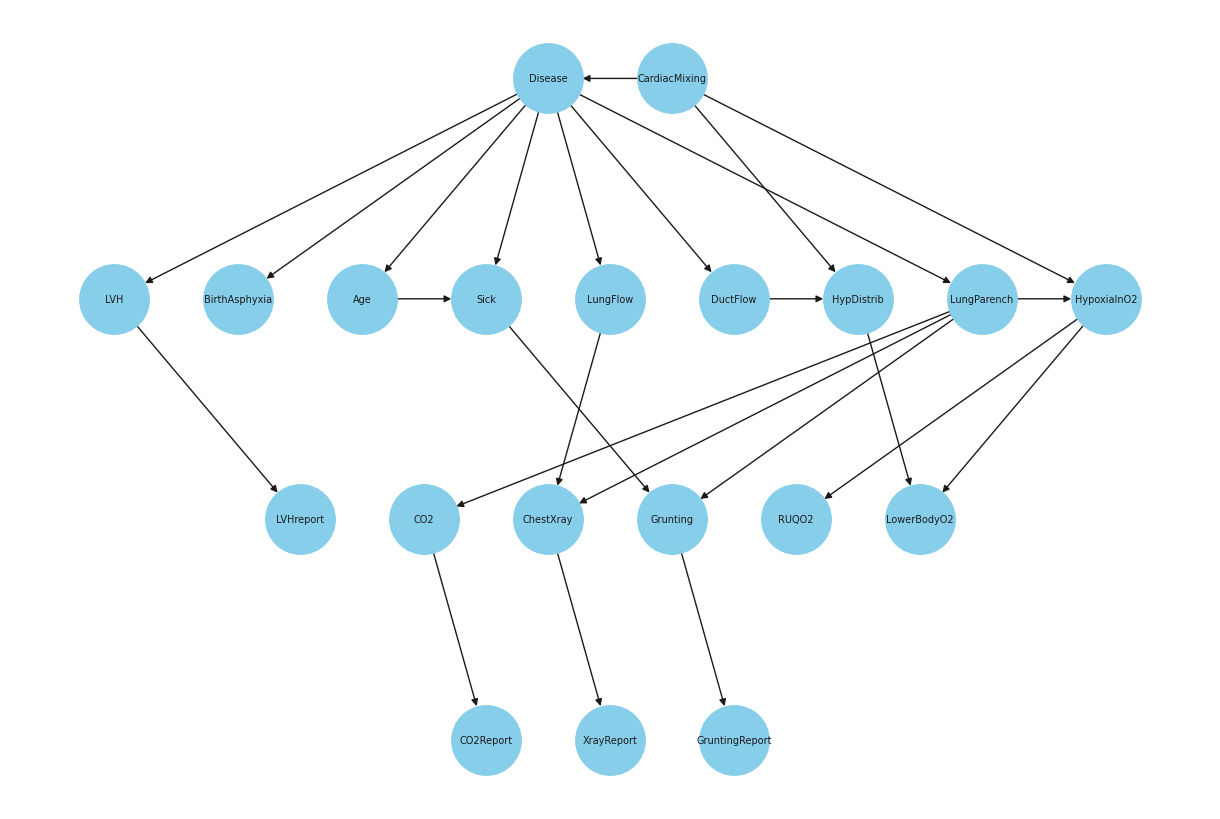

In [ ]:
nodos_por_filas = [
    [ 'Disease','CardiacMixing'],
    ['LVH','BirthAsphyxia', 'Age','Sick', 'LungFlow','DuctFlow','HypDistrib','LungParench','HypoxiaInO2'],
    ['LVHreport','CO2', 'ChestXray','Grunting','RUQO2','LowerBodyO2'],
    ['CO2Report','XrayReport','GruntingReport']
]

dibuja_por_niveles(nodos_por_filas, modelo_final)

In [ ]:
writer = BIFWriter(modelo_final)
writer.write_bif('modelo_final.bif')

## Inferencia (usando la red original), obtén:
    
* Distribución marginal de: CardiacMixing
* Estima mediante sample la distribución marginal de CardiacMixing, ¿se parece?
* Distribución conjunta de LowerBodyO2, GruntingReport,RUQO2
* ¿Cuál es la distribución de RUQO2 sabiendo que Sick=yes, CO2=Low y LungFlow=Normal? ¿Tienen sentido estas evidencias?
* ¿Cuál es la asignación más probable de Sick, CO2 y LungFlow en conjunto?
* Obtén la respuesta anterior mediante inferencia basada en muestreo para calcularla

### DISTRIBUCIÓN MARGINAL DE CardiacMixing POR ELIMINACIÓN DE VARIABLES Y POR MUESTREO

In [ ]:
inference_child = VariableElimination(child)
qCardiacMixing = inference_child.query(variables=['CardiacMixing'], show_progress=False)
print('\nDISTRIBUCIÓN MARGINAL DE CardiacMixing POR ELIMINACIÓN DE VARIABLES:')
print(qCardiacMixing)


DISTRIBUCIÓN MARGINAL DE CardiacMixing POR ELIMINACIÓN DE VARIABLES:
+-------------------------+----------------------+
| CardiacMixing           |   phi(CardiacMixing) |
+=========================+======================+
| CardiacMixing(None)     |               0.0546 |
+-------------------------+----------------------+
| CardiacMixing(Mild)     |               0.1301 |
+-------------------------+----------------------+
| CardiacMixing(Complete) |               0.5360 |
+-------------------------+----------------------+
| CardiacMixing(Transp.)  |               0.2793 |
+-------------------------+----------------------+


In [ ]:
inference_child_sampling = ApproxInference(child)
q_aproxCardiacMixing = inference_child_sampling.query(variables=['CardiacMixing'], n_samples=10000, show_progress=False)
print('\nDISTRIBUCIÓN MARGINAL APROXIMADA DE CardiacMixing POR MUESTREO:')
print(q_aproxCardiacMixing)


DISTRIBUCIÓN MARGINAL APROXIMADA DE CardiacMixing POR MUESTREO:
+-------------------------+----------------------+
| CardiacMixing           |   phi(CardiacMixing) |
+=========================+======================+
| CardiacMixing(Complete) |               0.5347 |
+-------------------------+----------------------+
| CardiacMixing(Mild)     |               0.1279 |
+-------------------------+----------------------+
| CardiacMixing(Transp.)  |               0.2860 |
+-------------------------+----------------------+
| CardiacMixing(None)     |               0.0514 |
+-------------------------+----------------------+


La estimación se asemeja bastante al valor teórico calculado con el método exacto de eliminación de variables.

### DISTRIBUCIÓN CONJUNTA DE (LowerBodyO2, GruntingReport, RUQO2).

In [ ]:
qConjunta = inference_child.query(variables=['LowerBodyO2', 'GruntingReport', 'RUQO2'], show_progress=False)
print('\nDISTRIBUCIÓN DE (LowerBodyO2, GruntingReport, RUQO2) POR ELIMINACIÓN DE VARIABLES:')
print(qConjunta)


DISTRIBUCIÓN DE (LowerBodyO2, GruntingReport, RUQO2) POR ELIMINACIÓN DE VARIABLES:
+-------------------+---------------------+-------------+-----------------------------------------+
| LowerBodyO2       | GruntingReport      | RUQO2       |   phi(LowerBodyO2,GruntingReport,RUQO2) |
+===================+=====================+=============+=========================================+
| LowerBodyO2(<5)   | GruntingReport(yes) | RUQO2(<5)   |                                  0.0378 |
+-------------------+---------------------+-------------+-----------------------------------------+
| LowerBodyO2(<5)   | GruntingReport(yes) | RUQO2(5-12) |                                  0.0460 |
+-------------------+---------------------+-------------+-----------------------------------------+
| LowerBodyO2(<5)   | GruntingReport(yes) | RUQO2(12+)  |                                  0.0124 |
+-------------------+---------------------+-------------+-----------------------------------------+
| LowerBodyO2(<5

### DISTRIBUCIÓN DE RUQO2 SUPONIENDO Sick=yes, CO2=Low Y LungFlow=Normal.

In [ ]:
child.get_markov_blanket('RUQO2')

['HypoxiaInO2']

El manto de Markov de RUQO2 consta solo de la variable HypoxiaInO2. De esta forma, si conociésemos HypoxiaInO2, no serviría condicionar por otras variables porque no influiría en la distribución. Como HypoxiaInO2 no es dado, es posible que otras variables puedan influir en función de los estados observados. Por otro lado, en el análisis exploratorio se observó que no hay influencia de las variables Sick y CO2 en RUQO2 pero sí posiblemente de LungFlow. Esto podría reflejarse en nuestra red. La distribución condicionada con la marginal parece semejarse, se puede probar que cambios en los estados de las evidencias produce cambios un poco más notables en la distribución. Por ello, sí puede tener sentido tomar estas evidencias. Cabe destacar que la probabilidad de que ocurra la evidencia es la más baja de todas las posibilidades con una probabilidad de 0.0055, teniendo en cuenta esto, podría no tener sentido la evidencia por la baja probabilidad de que ocurra.

In [ ]:
qRUQO2 = inference_child.query(variables=['RUQO2'], evidence={'Sick':'yes', 'CO2':'Low', 'LungFlow':'Normal'}, show_progress=False)
print('\nDISTRIBUCIÓN DE RUQO2 CON Sick=yes, CO2=Low Y LungFlow=Normal POR ELIMINACIÓN DE VARIABLES:')
print(qRUQO2)


DISTRIBUCIÓN DE RUQO2 CON Sick=yes, CO2=Low Y LungFlow=Normal POR ELIMINACIÓN DE VARIABLES:
+-------------+--------------+
| RUQO2       |   phi(RUQO2) |
+=============+==============+
| RUQO2(<5)   |       0.3407 |
+-------------+--------------+
| RUQO2(5-12) |       0.4827 |
+-------------+--------------+
| RUQO2(12+)  |       0.1766 |
+-------------+--------------+


In [ ]:
qRUQO2_marg = inference_child.query(variables=['RUQO2'], show_progress=False)
print('\nDISTRIBUCIÓN MARGINAL DE RUQO2 POR ELIMINACIÓN DE VARIABLES:')
print(qRUQO2_marg)


DISTRIBUCIÓN MARGINAL DE RUQO2 POR ELIMINACIÓN DE VARIABLES:
+-------------+--------------+
| RUQO2       |   phi(RUQO2) |
+=============+==============+
| RUQO2(<5)   |       0.3528 |
+-------------+--------------+
| RUQO2(5-12) |       0.4923 |
+-------------+--------------+
| RUQO2(12+)  |       0.1550 |
+-------------+--------------+


In [ ]:
# OTRAS EVIDENCIAS
qRUQO2_2 = inference_child.query(variables=['RUQO2'], evidence={'Sick':'yes', 'CO2':'Low', 'LungFlow':'High'}, show_progress=False)
print('\nDISTRIBUCIÓN DE RUQO2 CON Sick=yes, CO2=Low Y LungFlow=High POR ELIMINACIÓN DE VARIABLES:')
print(qRUQO2_2)


DISTRIBUCIÓN DE RUQO2 CON Sick=yes, CO2=Low Y LungFlow=High POR ELIMINACIÓN DE VARIABLES:
+-------------+--------------+
| RUQO2       |   phi(RUQO2) |
+=============+==============+
| RUQO2(<5)   |       0.3986 |
+-------------+--------------+
| RUQO2(5-12) |       0.4650 |
+-------------+--------------+
| RUQO2(12+)  |       0.1363 |
+-------------+--------------+


In [ ]:
# PROBABILIDAD DE QUE OCURRA LA EVIDENCIA
prob_evidence = inference_child.query(variables=['Sick', 'CO2', 'LungFlow'], show_progress=False)
print('\nDISTRIBUCIÓN DE (Sick, CO2, LungFlow) POR ELIMINACIÓN DE VARIABLES:')
print(prob_evidence)


DISTRIBUCIÓN DE (Sick, CO2, LungFlow) POR ELIMINACIÓN DE VARIABLES:
+-----------+-------------+------------------+--------------------------+
| Sick      | CO2         | LungFlow         |   phi(Sick,CO2,LungFlow) |
+===========+=============+==================+==========================+
| Sick(yes) | CO2(Normal) | LungFlow(Normal) |                   0.0494 |
+-----------+-------------+------------------+--------------------------+
| Sick(yes) | CO2(Normal) | LungFlow(Low)    |                   0.0933 |
+-----------+-------------+------------------+--------------------------+
| Sick(yes) | CO2(Normal) | LungFlow(High)   |                   0.0773 |
+-----------+-------------+------------------+--------------------------+
| Sick(yes) | CO2(Low)    | LungFlow(Normal) |                   0.0055 |
+-----------+-------------+------------------+--------------------------+
| Sick(yes) | CO2(Low)    | LungFlow(Low)    |                   0.0112 |
+-----------+-------------+----------------

### ASIGNACIÓN MÁS PROBABLE PARA Sick, CO2 Y LungFlow FORMA EXACTA Y CON MUESTREO.

In [ ]:
# ELIMINACIÓN DE VARIABLES
conj_mas_prob = inference_child.map_query(variables=['Sick', 'CO2', 'LungFlow'], show_progress=False)
print('\nASIGNACIÓN MÁS PROBABLE PARA (Sick, CO2 Y LungFlow) POR ELIMINACIÓN DE VARIABLES:')
print(conj_mas_prob)


ASIGNACIÓN MÁS PROBABLE PARA (Sick, CO2 Y LungFlow) POR ELIMINACIÓN DE VARIABLES:
{'LungFlow': 'Low', 'CO2': 'Normal', 'Sick': 'no'}


In [ ]:
# MUESTREO: AL NO TENER EL MÉTODO map_query PARA TENER LA COMBINACIÓN DIRECTAMENTE,
# HALLAMOS LA DISTRIBUCIÓN APROXIMADA Y OBSERVAMOS LA DE MAYOR PROBABILIDAD. LA
# COMBINACIÓN MÁS PROBABLE ES: Sick(no)  | CO2(Normal) | LungFlow(Low), COINCI-
# DIENDO CON EL MÉTODO EXACTO.
qConj2 = inference_child_sampling.query(variables=['Sick', 'CO2', 'LungFlow'], n_samples=100000, show_progress=False)
print('\nDISTRIBUCIÓN PARA (Sick, CO2 Y LungFlow) POR MUESTREO:')
print(qConj2)


DISTRIBUCIÓN PARA (Sick, CO2 Y LungFlow) POR MUESTREO:
+-----------+-------------+------------------+--------------------------+
| Sick      | CO2         | LungFlow         |   phi(Sick,CO2,LungFlow) |
+===========+=============+==================+==========================+
| Sick(yes) | CO2(Normal) | LungFlow(Normal) |                   0.0497 |
+-----------+-------------+------------------+--------------------------+
| Sick(yes) | CO2(Normal) | LungFlow(High)   |                   0.0773 |
+-----------+-------------+------------------+--------------------------+
| Sick(yes) | CO2(Normal) | LungFlow(Low)    |                   0.0915 |
+-----------+-------------+------------------+--------------------------+
| Sick(yes) | CO2(High)   | LungFlow(Normal) |                   0.0211 |
+-----------+-------------+------------------+--------------------------+
| Sick(yes) | CO2(High)   | LungFlow(High)   |                   0.0240 |
+-----------+-------------+------------------+----------